In [1]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
from PIL import Image
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import roc_curve, auc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

# 1. Business Understanding

**Business Objectives:

– Confirm the presence of a breast tumor:
Provide reliable support to the physician to determine whether the data indicate a suspicious tumor requiring medical intervention.

– Characterize the tumor to guide clinical decisions:
Offer clear indications on whether the tumor is benign or malignant.

– Detect early risk factors in healthy patients and recommend appropriate preventive actions.

**Data science objectives:

– Classify tumor type:
Build a model to distinguish between benign and malignant tumors based on imaging and clinical features. (dataset de base + dataset simple ajoutée)

– Detect tumor presence:
Develop a predictive model to classify patient data as indicative of a tumor or not, providing a reliable alert for potential breast cancer. (dataset image)

– Identify risk factors in healthy patients:
Analyze patient data to detect early indicators of increased breast cancer risk and generate actionable preventive recommendations.
(dataset de base + dataset simple ajoutée avec plus de concentration sur les variables qui traite la maladie)

# 2.Data Understanding

# 2.1 Data Understanding - Data article

# Data Loading & Initial Inspection

In [7]:
# Load the dataset
df = pd.read_csv('data.csv', header=0)

# Remove empty column if exists
if df.columns[-1] == 'NaN' or pd.isna(df.columns[-1]):
    df = df.iloc[:, :-1]

print(" WDBC Dataset Loaded Successfully!")
print(f" Dataset Shape: {df.shape}")
print(f" Samples: {df.shape[0]}, Features: {df.shape[1] - 2}")  # Excluding ID and diagnosis

# Display first few rows
print("\n First 5 Rows:")
print(df.head())

# Basic dataset information
print("\n Dataset Info:")
print(df.info())

# Column names
print(f"\n Column Names:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

 WDBC Dataset Loaded Successfully!
 Dataset Shape: (569, 33)
 Samples: 569, Features: 31

 First 5 Rows:
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.1328

# Target Variable Analysis

Target Value Distribution:
   Benign (B): 357 samples (62.7%)
   Malignant (M): 212 samples (37.3%)


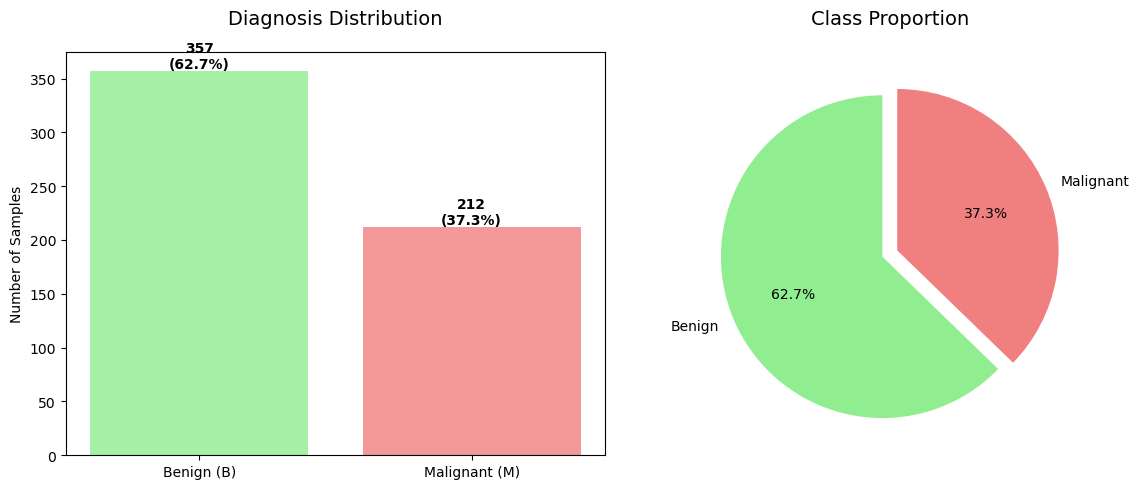

In [9]:
target_column = 'diagnosis' if 'diagnosis' in df.columns else df.columns[1]
target_dist = df[target_column].value_counts()

print("Target Value Distribution:")
print(f"   Benign (B): {target_dist['B']} samples ({target_dist['B']/len(df)*100:.1f}%)")
print(f"   Malignant (M): {target_dist['M']} samples ({target_dist['M']/len(df)*100:.1f}%)")

# Enhanced visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
bars = plt.bar(['Benign (B)', 'Malignant (M)'], target_dist.values, 
               color=['lightgreen', 'lightcoral'], alpha=0.8)
plt.title('Diagnosis Distribution', fontsize=14, pad=20)
plt.ylabel('Number of Samples')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({height/len(df)*100:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=['Benign', 'Malignant'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'],
        startangle=90, explode=(0.05, 0.05))
plt.title('Class Proportion', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

#  Feature Analysis

In [13]:
# Feature groups
mean_features = [col for col in df.columns if 'mean' in col]
se_features = [col for col in df.columns if '_se' in col]
worst_features = [col for col in df.columns if 'worst' in col]

print(f"\n Feature Categories:")
print(f"   Mean Features: {len(mean_features)}")
print(f"   Standard Error Features: {len(se_features)}")
print(f"   Worst Features: {len(worst_features)}")
print(f"   Total Features: {len(mean_features) + len(se_features) + len(worst_features)}")


 Feature Categories:
   Mean Features: 10
   Standard Error Features: 10
   Worst Features: 10
   Total Features: 30


# Data Quality Assessment

In [17]:
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('id')

# Missing values analysis
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Analysis:")
print(missing_info[missing_info['Missing Values'] > 0])

if missing_info['Missing Values'].sum() == 0:
    print(" No missing values found!")
else:
    print(f" Total missing values: {missing_info['Missing Values'].sum()}")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f" Duplicate rows: {duplicates}")

# Check data types consistency
print(f"\n Data Types Analysis:")
print(df.dtypes.value_counts())

# Check for constant columns
constant_columns = []
for col in numeric_features:
    if df[col].nunique() == 1:
        constant_columns.append(col)

print(f" Constant columns: {len(constant_columns)}")

# Check for infinite values
infinite_values = np.isinf(df[numeric_features]).sum().sum()
print(f"  Infinite values: {infinite_values}")

Missing Values Analysis:
             Missing Values  Percentage
Unnamed: 32             569       100.0
 Total missing values: 569
 Duplicate rows: 0

 Data Types Analysis:
float64    31
int64       1
object      1
Name: count, dtype: int64
 Constant columns: 0
  Infinite values: 0


# Feature Distributions by Class

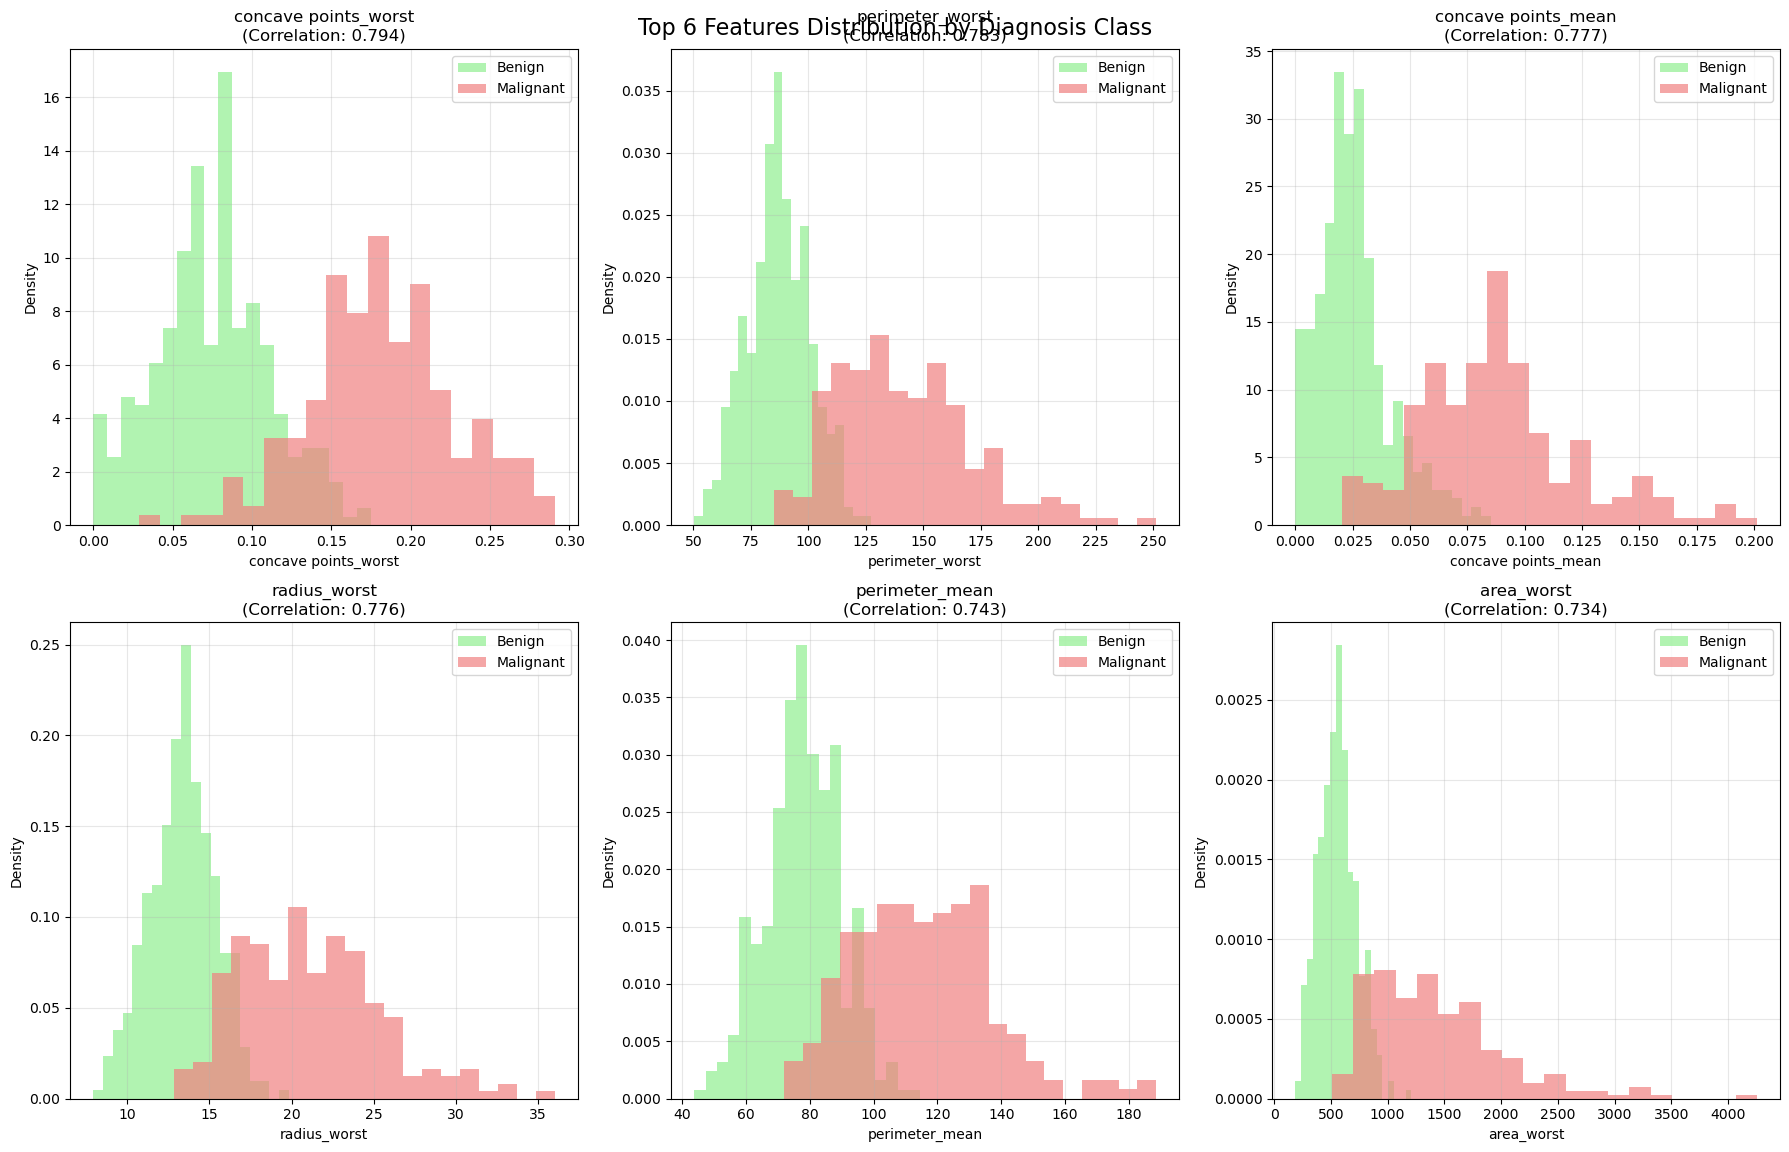

In [20]:
# Prepare data for visualization
X = df.drop(['id', target_column], axis=1)
y = df[target_column].map({'M': 1, 'B': 0})

# Select top 6 features for detailed visualization
correlation_with_target = X.corrwith(y).abs().sort_values(ascending=False)
top_6_features = correlation_with_target.head(6).index

# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_6_features):
    # Plot distributions by class
    df[df[target_column] == 'B'][feature].hist(
        alpha=0.7, label='Benign', color='lightgreen', ax=axes[i], bins=20, density=True)
    df[df[target_column] == 'M'][feature].hist(
        alpha=0.7, label='Malignant', color='lightcoral', ax=axes[i], bins=20, density=True)
    
    correlation = correlation_with_target[feature]
    axes[i].set_title(f'{feature}\n(Correlation: {correlation:.3f})', fontsize=12)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Top 6 Features Distribution by Diagnosis Class', fontsize=16, y=0.95)
plt.tight_layout()
plt.show()

# Correlation Analysis

Top 10 Features Correlated with Diagnosis:
    1. concave points_worst     :   0.794
    2. perimeter_worst          :   0.783
    3. concave points_mean      :   0.777
    4. radius_worst             :   0.776
    5. perimeter_mean           :   0.743
    6. area_worst               :   0.734
    7. radius_mean              :   0.730
    8. area_mean                :   0.709
    9. concavity_mean           :   0.696
   10. concavity_worst          :   0.660

Bottom 10 Features Correlated with Diagnosis:
    1. symmetry_mean            :   0.330
    2. fractal_dimension_worst  :   0.324
    3. compactness_se           :   0.293
    4. concavity_se             :   0.254
    5. fractal_dimension_se     :   0.078
    6. symmetry_se              :  -0.007
    7. texture_se               :  -0.008
    8. fractal_dimension_mean   :  -0.013
    9. smoothness_se            :  -0.067
   10. Unnamed: 32              :     nan


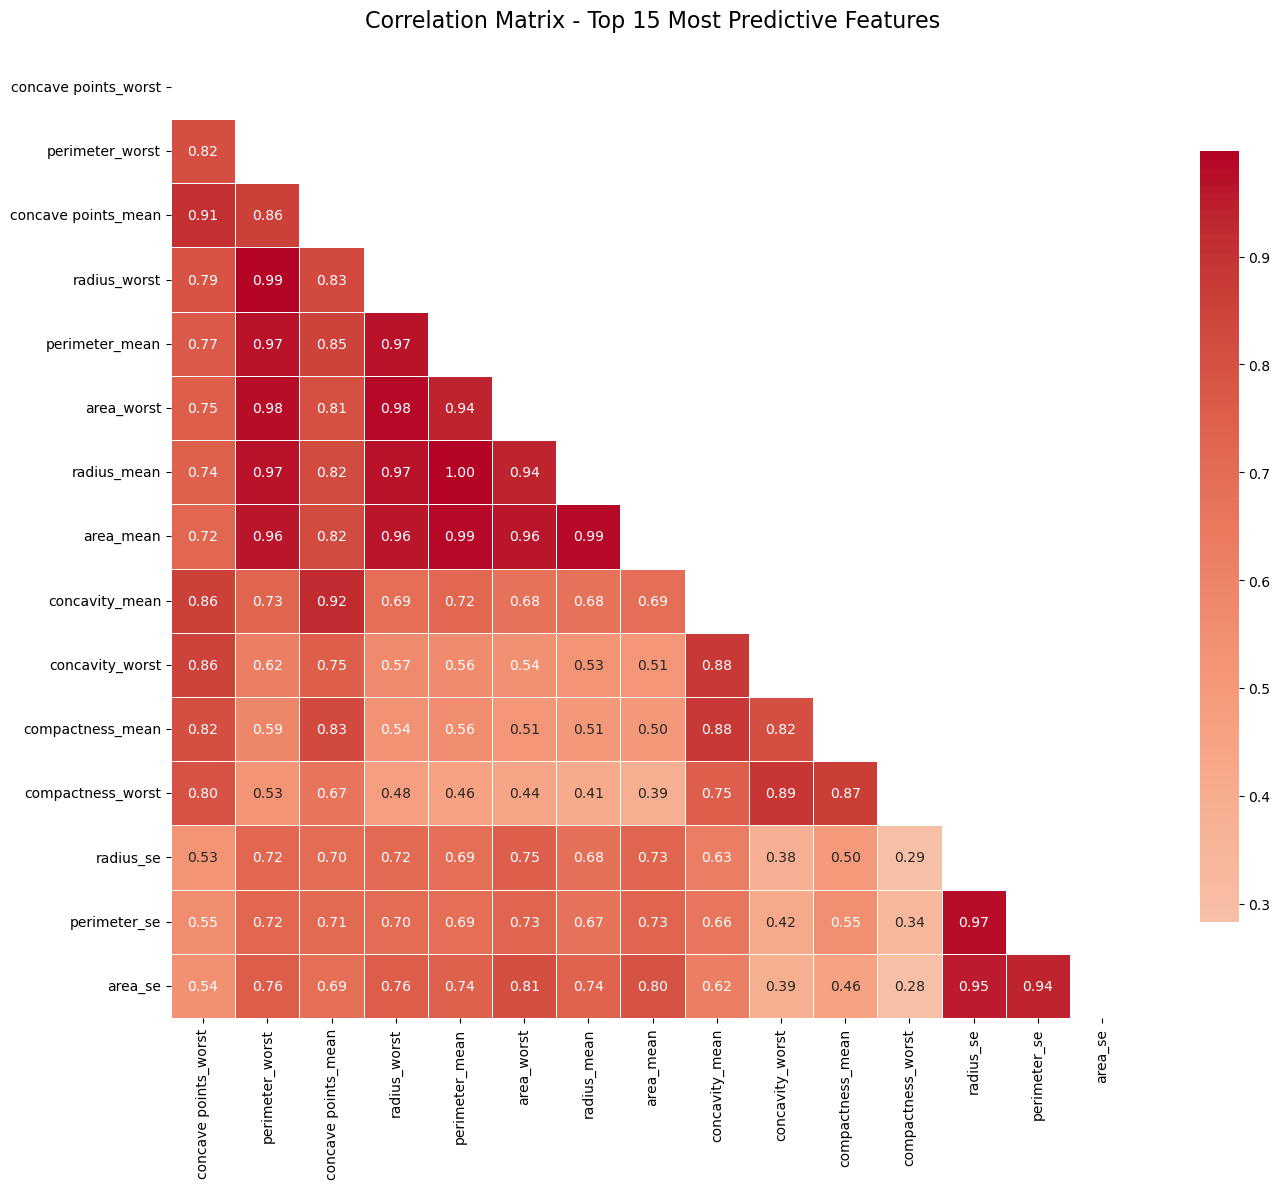

In [22]:
# Calculate correlation matrix
correlation_matrix = X.corrwith(y).sort_values(ascending=False)

print("Top 10 Features Correlated with Diagnosis:")
for i, (feature, corr) in enumerate(correlation_matrix.head(10).items(), 1):
    print(f"   {i:2d}. {feature:25}: {corr:7.3f}")

print(f"\nBottom 10 Features Correlated with Diagnosis:")
for i, (feature, corr) in enumerate(correlation_matrix.tail(10).items(), 1):
    print(f"   {i:2d}. {feature:25}: {corr:7.3f}")

# Visualize correlation heatmap for top 15 features
plt.figure(figsize=(15, 12))
top_15_features = correlation_matrix.head(15).index
corr_top_15 = X[top_15_features].corr()

mask = np.triu(np.ones_like(corr_top_15, dtype=bool))
sns.heatmap(corr_top_15, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix - Top 15 Most Predictive Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Outlier Detection

Outlier Analysis (IQR method) - Top 10 Features:
                Feature  Outliers  Percentage
0  concave points_worst         0    0.000000
1       perimeter_worst        15    2.636204
2   concave points_mean        10    1.757469
3          radius_worst        17    2.987698
4        perimeter_mean        13    2.284710
5            area_worst        35    6.151142
6           radius_mean        14    2.460457
7             area_mean        25    4.393673
8        concavity_mean        18    3.163445
9       concavity_worst        12    2.108963


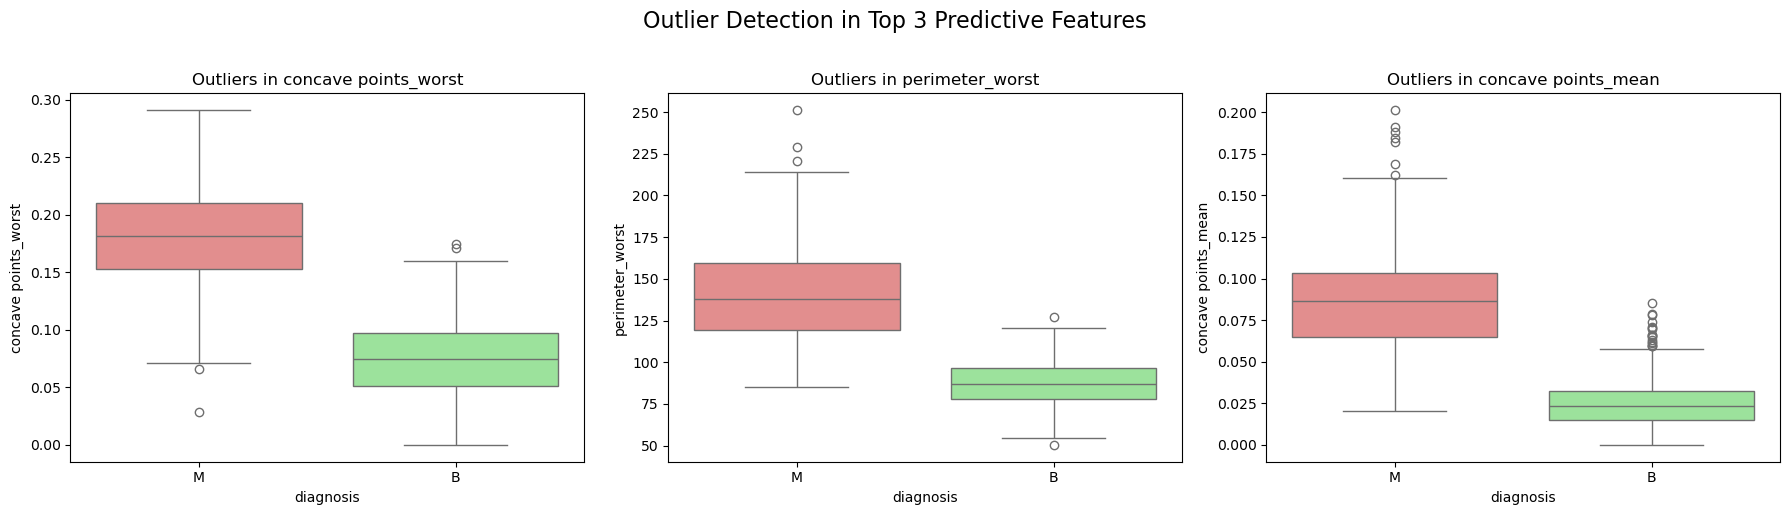

In [25]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return len(outliers)

print("Outlier Analysis (IQR method) - Top 10 Features:")
outlier_info = []
for feature in correlation_matrix.head(10).index:
    outliers_count = detect_outliers_iqr(df, feature)
    outlier_percentage = (outliers_count / len(df)) * 100
    outlier_info.append({
        'Feature': feature,
        'Outliers': outliers_count,
        'Percentage': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)

# Visualize outliers for top 3 features
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
top_3_features = correlation_matrix.head(3).index

for i, feature in enumerate(top_3_features):
    sns.boxplot(x=target_column, y=feature, data=df, ax=axes[i], 
                palette={'B': 'lightgreen', 'M': 'lightcoral'})
    axes[i].set_title(f'Outliers in {feature}')
    axes[i].set_ylabel(feature)

plt.suptitle('Outlier Detection in Top 3 Predictive Features', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# 2.2 Data Understanding - Data clinic

# Data Loading & Initial Inspection

In [130]:
# Load the clinical dataset
clinical_df = pd.read_csv('data2.csv')  

print(" Clinical Dataset Loaded Successfully!")
print(f" Dataset Shape: {clinical_df.shape}")
print(f" Samples: {clinical_df.shape[0]}, Features: {clinical_df.shape[1]}")

# Display first few rows
print("\n First 5 Rows:")
print(clinical_df.head())

# Basic dataset information
print("\n Dataset Info:")
print(clinical_df.info())

# Column names
print(f"\n Column Names:")
for i, col in enumerate(clinical_df.columns, 1):
    print(f"   {i:2d}. {col}")

 Clinical Dataset Loaded Successfully!
 Dataset Shape: (4000, 10)
 Samples: 4000, Features: 10

 First 5 Rows:
   Age        BMI  Glucose  Insulin      HOMA   Leptin  Adiponectin  Resistin  \
0   54  35.207389      103    5.642  1.378660  65.6699     9.738408  31.17499   
1   52  22.978520      132    6.054  1.145435  47.5445     3.627241  23.03327   
2   32  21.101341       87    5.668  1.008595  50.5074     5.067841   9.51156   
3   42  26.761205      132    2.875  1.003837  16.8972    10.096475   9.75652   
4   55  34.232520       76    3.120  1.597721  17.6852    11.845054  17.21541   

     MCP.1  Classification  
0  197.660               1  
1  423.361               2  
2  897.034               2  
3  267.744               1  
4  788.552               2  

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age       

# Target Variable Analysis

In [135]:
# Analyze the target variable 'Classification'
target_column = 'Classification'
target_dist = clinical_df[target_column].value_counts().sort_index()

print("Target Value Distribution:")
print(f"   1 = Healthy controls: {target_dist[1]} samples ({target_dist[1]/len(clinical_df)*100:.1f}%)")
print(f"   2 = Patients: {target_dist[2]} samples ({target_dist[2]/len(clinical_df)*100:.1f}%)")

Target Value Distribution:
   1 = Healthy controls: 1784 samples (44.6%)
   2 = Patients: 2216 samples (55.4%)


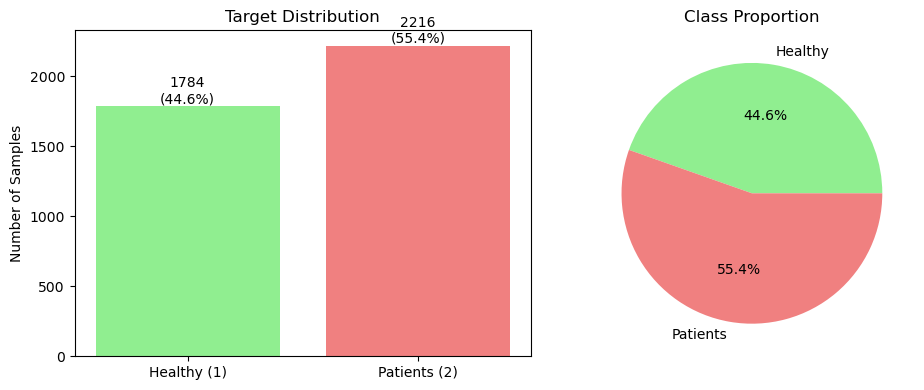

In [137]:
# Visualization
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
bars = plt.bar(['Healthy (1)', 'Patients (2)'], target_dist.values, 
               color=['lightgreen', 'lightcoral'])
plt.title('Target Distribution')
plt.ylabel('Number of Samples')
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height}\n({height/len(clinical_df)*100:.1f}%)',
             ha='center', va='bottom')

plt.subplot(1, 2, 2)
plt.pie(target_dist.values, labels=['Healthy', 'Patients'], 
        autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
plt.title('Class Proportion')

plt.tight_layout()
plt.show()

# Feature Analysis & Description

In [140]:
# Feature descriptions based on attribute information
feature_descriptions = {
    'Age': 'Patient age in years',
    'BMI': 'Body Mass Index (kg/m²)',
    'Glucose': 'Blood glucose level (mg/dL)',
    'Insulin': 'Insulin level (µU/mL)',
    'HOMA': 'Homeostatic Model Assessment',
    'Leptin': 'Leptin hormone level (ng/mL)',
    'Adiponectin': 'Adiponectin level (µg/mL)',
    'Resistin': 'Resistin level (ng/mL)',
    'MCP.1': 'Monocyte Chemoattractant Protein-1 (pg/dL)'
}

print("Feature Descriptions:")
for feature, description in feature_descriptions.items():
    print(f"   • {feature}: {description}")

# Basic statistics
print(f"\n Statistical Summary:")
print(clinical_df.describe())

Feature Descriptions:
   • Age: Patient age in years
   • BMI: Body Mass Index (kg/m²)
   • Glucose: Blood glucose level (mg/dL)
   • Insulin: Insulin level (µU/mL)
   • HOMA: Homeostatic Model Assessment
   • Leptin: Leptin hormone level (ng/mL)
   • Adiponectin: Adiponectin level (µg/mL)
   • Resistin: Resistin level (ng/mL)
   • MCP.1: Monocyte Chemoattractant Protein-1 (pg/dL)

 Statistical Summary:
              Age          BMI      Glucose      Insulin         HOMA  \
count  4000.00000  4000.000000  4000.000000  4000.000000  4000.000000   
mean     56.21075    27.422280   113.876500     8.654001     2.024332   
std      17.80965     4.413884    25.837795     6.435160     1.625638   
min      32.00000    20.690751    76.000000     2.821000     0.590033   
25%      39.00000    23.079053    76.000000     4.421750     0.970090   
50%      56.00000    27.558485   131.000000     5.818000     1.373842   
75%      72.00000    30.814916   134.000000    10.466250     2.502776   
max      

# Data Quality Assessment

In [143]:
# Missing values analysis
missing_values = clinical_df.isnull().sum()
missing_percentage = (missing_values / len(clinical_df)) * 100

missing_info = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})

print("Missing Values Summary:")
print(missing_info[missing_info['Missing Values'] > 0])

if missing_info['Missing Values'].sum() == 0:
    print(" No missing values found!")
else:
    print(f"  Total missing values: {missing_info['Missing Values'].sum()}")

# Check for duplicates
duplicates = clinical_df.duplicated().sum()
print(f" Duplicate rows: {duplicates}")

# Check data types
print(f"\n Data Types:")
print(clinical_df.dtypes.value_counts())

Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
 No missing values found!
 Duplicate rows: 0

 Data Types:
float64    7
int64      3
Name: count, dtype: int64


# Feature Distributions by Class

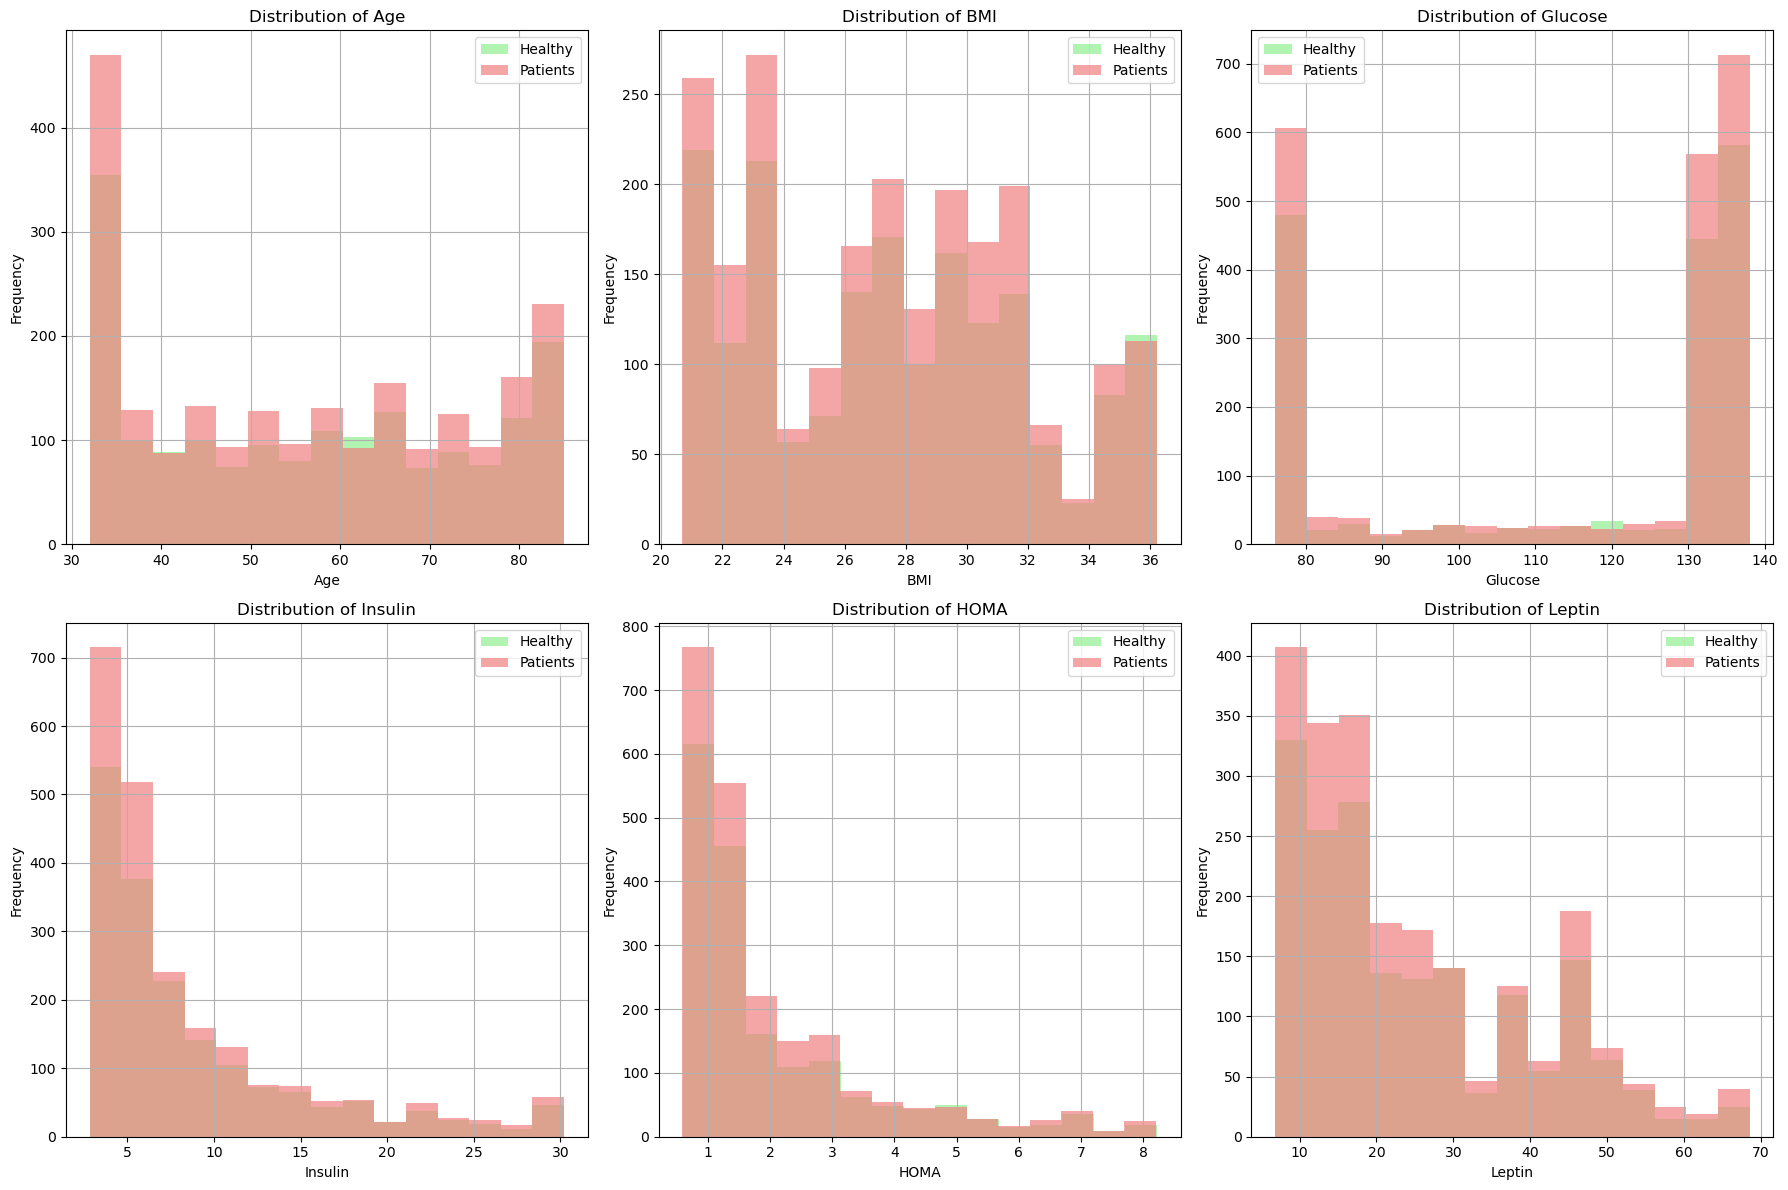

In [146]:
# Select numerical features (exclude target)
numerical_features = [col for col in clinical_df.columns if col != 'Classification']

# Create distribution plots for top 6 features
top_features = numerical_features[:6]  # First 6 features

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Plot distributions by class
    clinical_df[clinical_df['Classification'] == 1][feature].hist(
        alpha=0.7, label='Healthy', color='lightgreen', ax=axes[i], bins=15)
    clinical_df[clinical_df['Classification'] == 2][feature].hist(
        alpha=0.7, label='Patients', color='lightcoral', ax=axes[i], bins=15)
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Correlation Analysis

Feature Correlations with Target (Classification):
   Resistin       :   0.026
   MCP.1          :   0.006
   Glucose        :  -0.005
   Leptin         :  -0.005
   Adiponectin    :  -0.007
   Age            :  -0.008
   BMI            :  -0.009
   HOMA           :  -0.012
   Insulin        :  -0.017


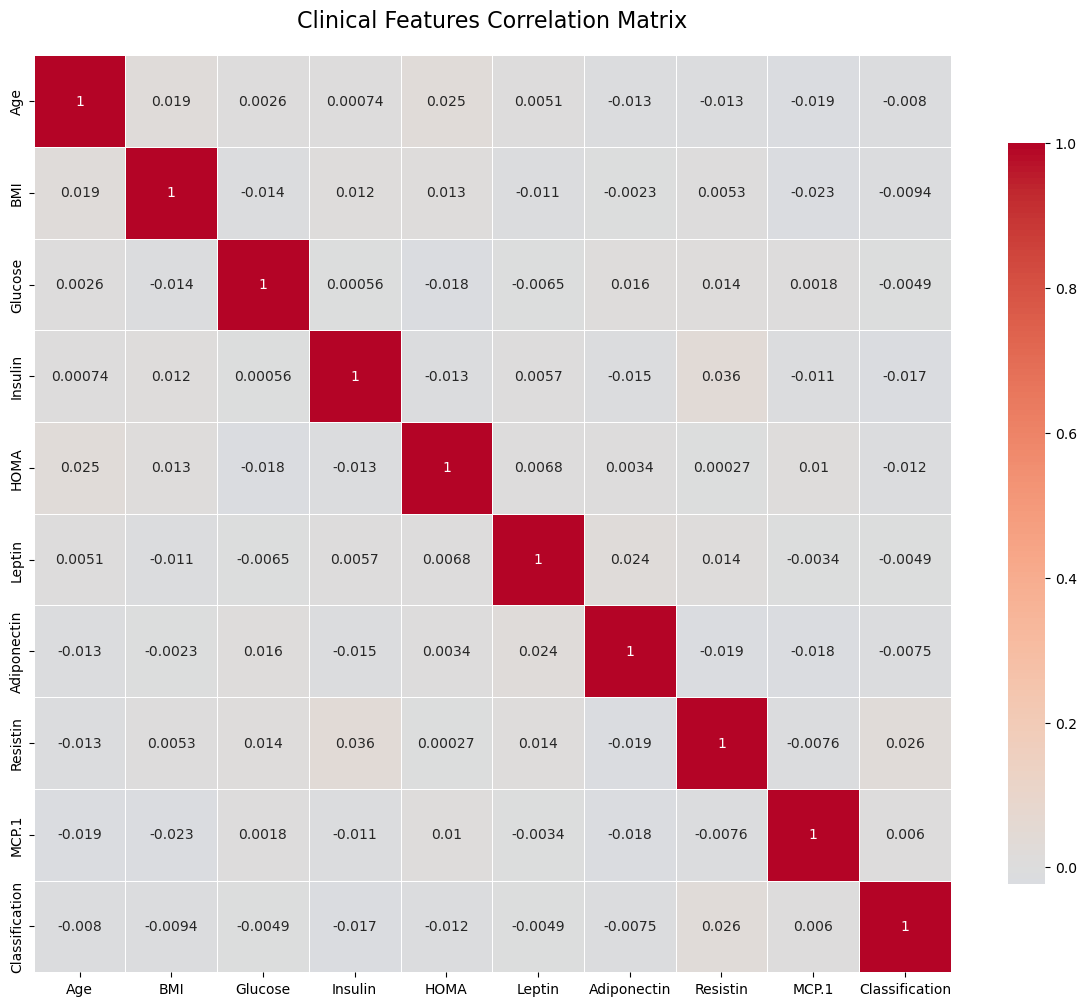

In [149]:
# Calculate correlation matrix
correlation_matrix = clinical_df.corr()

# Correlation with target variable
target_correlations = correlation_matrix['Classification'].sort_values(ascending=False)

print("Feature Correlations with Target (Classification):")
for feature, corr in target_correlations.items():
    if feature != 'Classification':
        print(f"   {feature:15}: {corr:7.3f}")

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Clinical Features Correlation Matrix', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

# Outlier Detection

In [152]:
def detect_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]
    return len(outliers)

print("Outlier Analysis (IQR method):")
outlier_info = []
for feature in numerical_features:
    outliers_count = detect_outliers_iqr(clinical_df, feature)
    outlier_percentage = (outliers_count / len(clinical_df)) * 100
    outlier_info.append({
        'Feature': feature,
        'Outliers': outliers_count,
        'Percentage': outlier_percentage
    })

outlier_df = pd.DataFrame(outlier_info)
print(outlier_df)

Outlier Analysis (IQR method):
       Feature  Outliers  Percentage
0          Age         0       0.000
1          BMI         0       0.000
2      Glucose         0       0.000
3      Insulin       352       8.800
4         HOMA       343       8.575
5       Leptin         0       0.000
6  Adiponectin       281       7.025
7     Resistin        62       1.550
8        MCP.1         0       0.000


# Key Insights for Risk Factor Identification

In [155]:
# Analyze features with highest correlation to patient status
high_corr_features = target_correlations[1:4]  # Top 3 features (excluding target itself)

print("Top Features Correlated with Patient Status:")
for feature, corr in high_corr_features.items():
    # Calculate mean values by class
    healthy_mean = clinical_df[clinical_df['Classification'] == 1][feature].mean()
    patient_mean = clinical_df[clinical_df['Classification'] == 2][feature].mean()
    
    print(f"   • {feature}:")
    print(f"        Correlation: {corr:.3f}")
    print(f"        Healthy mean: {healthy_mean:.2f}")
    print(f"        Patient mean: {patient_mean:.2f}")
    print(f"        Difference: {patient_mean - healthy_mean:.2f}")

# Potential risk factors based on medical knowledge
print(f"\n POTENTIAL RISK FACTORS ANALYSIS:")
print(f"   • BMI: Higher BMI may correlate with increased cancer risk")
print(f"   • Glucose/Insulin: Metabolic factors linked to cancer risk")
print(f"   • Hormone levels (Leptin, Adiponectin, Resistin): Adipokines related to obesity and cancer")
print(f"   • MCP-1: Inflammatory marker associated with cancer progression")

Top Features Correlated with Patient Status:
   • Resistin:
        Correlation: 0.026
        Healthy mean: 12.84
        Patient mean: 13.23
        Difference: 0.39
   • MCP.1:
        Correlation: 0.006
        Healthy mean: 510.49
        Patient mean: 513.55
        Difference: 3.06
   • Glucose:
        Correlation: -0.005
        Healthy mean: 114.02
        Patient mean: 113.76
        Difference: -0.25

 POTENTIAL RISK FACTORS ANALYSIS:
   • BMI: Higher BMI may correlate with increased cancer risk
   • Glucose/Insulin: Metabolic factors linked to cancer risk
   • Hormone levels (Leptin, Adiponectin, Resistin): Adipokines related to obesity and cancer
   • MCP-1: Inflammatory marker associated with cancer progression


# 2.3 Data Understanding - Data images

In [ ]:
root = r"Images histopathologies"

total_count = 0
class_0_count = 0
class_1_count = 0

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for class_label in ["0", "1"]:
        class_path = os.path.join(patient_path, class_label)
        if not os.path.isdir(class_path):
            continue
        
        count = len([f for f in os.listdir(class_path)
                     if f.endswith(".png")])

        total_count += count

        if class_label == "0":
            class_0_count += count
        else:
            class_1_count += count

print("Total images:", total_count)
print("Class 0 (non-IDC):", class_0_count)
print("Class 1 (IDC):", class_1_count)

In [ ]:
rows = []

for patient_id in os.listdir(root):
    patient_path = os.path.join(root, patient_id)
    if not os.path.isdir(patient_path):
        continue
    
    for label in ["0", "1"]:
        label_path = os.path.join(patient_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for fname in os.listdir(label_path):
            if fname.endswith(".png"):
                rows.append({
                    "patient_id": int(patient_id),
                    "label": int(label),
                    "filename": os.path.join(label_path, fname)
                })

df = pd.DataFrame(rows)
print(df.head())
print(df.shape)

In [ ]:
#datasets des id des patients
patients = df["patient_id"].unique()

train_patients, test_patients = train_test_split(patients, test_size=0.2, random_state=42)
train_patients, val_patients = train_test_split(train_patients, test_size=0.1, random_state=42)

df_train_images = df[df["patient_id"].isin(train_patients)]
df_val_images = df[df["patient_id"].isin(val_patients)]
df_test_images = df[df["patient_id"].isin(test_patients)]

In [ ]:
def echantillon_images(df, n=5):
    sample = df.sample(n)   # randomly pick n rows

    plt.figure(figsize=(15, 3))

    for i, (_, row) in enumerate(sample.iterrows()):
        img = Image.open(row["filename"])

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row['label']}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

echantillon_images(df_train_images, n=5)

# 3.Data Preparation

# 3.1 Data Preparation - Data article

# Data Loading & Target Encoding

In [28]:
# Load the dataset
df = pd.read_csv('data.csv', header=0)

# Remove empty column if exists
if df.columns[-1] == 'NaN' or pd.isna(df.columns[-1]):
    df = df.iloc[:, :-1]

print(" Dataset loaded successfully!")
print(f"   Shape: {df.shape}")

# Identify target column (assuming it's the second column as per WDBC standard)
target_column = 'diagnosis' if 'diagnosis' in df.columns else df.columns[1]
print(f" Target column: {target_column}")

# Encode target variable: M=1, B=0 (Malignant=1, Benign=0)
df[target_column] = df[target_column].map({'M': 1, 'B': 0})

print(f" Target encoded: Malignant=1, Benign=0")
print(f"   Class distribution: {df[target_column].value_counts().to_dict()}")

 Dataset loaded successfully!
   Shape: (569, 33)
 Target column: diagnosis
 Target encoded: Malignant=1, Benign=0
   Class distribution: {0: 357, 1: 212}


# Feature-Target Separation

In [31]:
# Separate features and target
X = df.drop([df.columns[0], target_column], axis=1)  # Drop ID and target
y = df[target_column]

# CORRECTION - Vérifier et ajuster le nombre de caractéristiques
print(f"\n Vérification du nombre de caractéristiques:")
print(f"   Caractéristiques actuelles: {X.shape[1]}")
print(f"   Caractéristiques attendues selon l'article: 30")

if X.shape[1] > 30:
    print(f"  Attention: {X.shape[1]} caractéristiques au lieu de 30")
    print("   Conserver uniquement les 30 premières caractéristiques comme dans l'article...")
    
    # Afficher les noms des colonnes actuelles pour vérification
    print("   Noms des colonnes actuelles:", X.columns.tolist())
    
    # Garder seulement les 30 premières colonnes (les 30 caractéristiques de l'article)
    X = X.iloc[:, :30]
    
    print(f" Correction appliquée: {X.shape[1]} caractéristiques")
    print("   Noms des colonnes après correction:", X.columns.tolist())
elif X.shape[1] == 30:
    print(" Nombre de caractéristiques correct (30)")
else:
    print(f"  Nombre inattendu de caractéristiques: {X.shape[1]}")

print(f"\n Feature-Target Separation:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Feature names: {list(X.columns)}")


 Vérification du nombre de caractéristiques:
   Caractéristiques actuelles: 31
   Caractéristiques attendues selon l'article: 30
  Attention: 31 caractéristiques au lieu de 30
   Conserver uniquement les 30 premières caractéristiques comme dans l'article...
   Noms des colonnes actuelles: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32']
 Correction appliquée: 30 caractéristiques
   Noms des colonnes après correction: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'sm

# Train-Test Split (70%-30%)

In [34]:
# Split the data exactly as described in the article
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,  # For reproducibility
    stratify=y        # Maintain class distribution
)

print(f"\n Train-Test Split (70%-30%):")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"   Training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"   Testing class distribution: {pd.Series(y_test).value_counts().to_dict()}")


 Train-Test Split (70%-30%):
   Training set: 398 samples (69.9%)
   Testing set: 171 samples (30.1%)
   Training class distribution: {0: 250, 1: 148}
   Testing class distribution: {0: 107, 1: 64}


# Feature Standardization

In [37]:
# Standardize features using z-score normalization (as in the paper)
scaler = StandardScaler()

# Fit on training data, transform both training and testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print(f"\n Feature Standardization (Z-score):")
print(f"   Training set mean: {X_train_scaled.mean().mean():.6f}")
print(f"   Training set std: {X_train_scaled.std().mean():.6f}")
print(f"   Testing set mean: {X_test_scaled.mean().mean():.6f}")
print(f"   Testing set std: {X_test_scaled.std().mean():.6f}")
print(" Features standardized to mean=0, std=1")


 Feature Standardization (Z-score):
   Training set mean: 0.000000
   Training set std: 1.001259
   Testing set mean: 0.012440
   Testing set std: 0.970886
 Features standardized to mean=0, std=1


# Data Preparation Verification

In [40]:
# Verify the preparation
print(f"\n DATA PREPARATION VERIFICATION:")
print(f"   Original data shape: {df.shape}")
print(f"   Final training shape: {X_train_scaled.shape}")
print(f"   Final testing shape: {X_test_scaled.shape}")
print(f"   Data types consistent: {X_train_scaled.dtypes.nunique() == 1}")

# Check standardization
print(f"\n Standardization Quality Check:")
print("   Training set statistics (first 5 features):")
for i, col in enumerate(X_train_scaled.columns[:5]):
    print(f"     {col}: mean={X_train_scaled[col].mean():.3f}, std={X_train_scaled[col].std():.3f}")


 DATA PREPARATION VERIFICATION:
   Original data shape: (569, 33)
   Final training shape: (398, 30)
   Final testing shape: (171, 30)
   Data types consistent: True

 Standardization Quality Check:
   Training set statistics (first 5 features):
     radius_mean: mean=0.000, std=1.001
     texture_mean: mean=-0.000, std=1.001
     perimeter_mean: mean=0.000, std=1.001
     area_mean: mean=0.000, std=1.001
     smoothness_mean: mean=-0.000, std=1.001


# Save Prepared Data

In [43]:
# Save prepared data for reproducibility
prepared_data = {
    'X_train': X_train_scaled,
    'X_test': X_test_scaled,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X.columns.tolist(),
    'scaler': scaler
}

print(f"\n Data prepared and saved for modeling!")
print(f"   Training samples: {len(X_train_scaled)}")
print(f"   Testing samples: {len(X_test_scaled)}")
print(f"   Features: {len(X.columns)}")
print(f"   Ready for all 6 algorithms from the paper")


 Data prepared and saved for modeling!
   Training samples: 398
   Testing samples: 171
   Features: 30
   Ready for all 6 algorithms from the paper


# Quick Visualization of Prepared Data

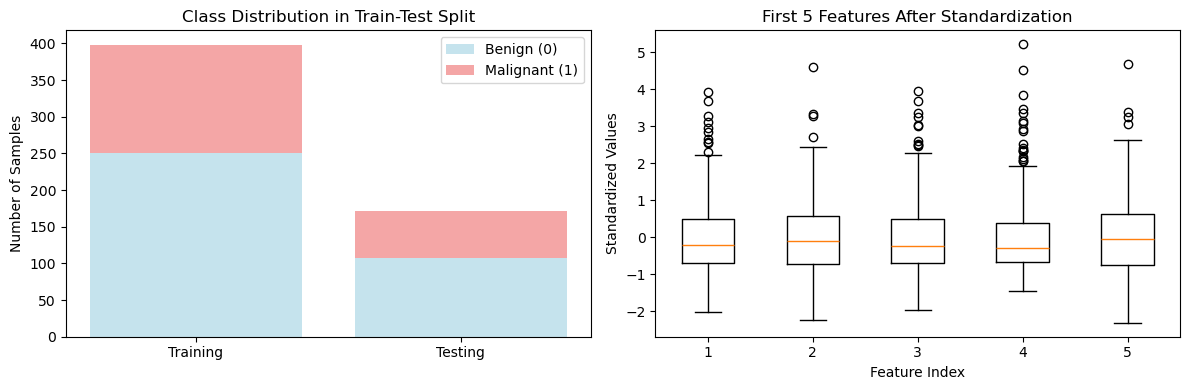

In [46]:
# Visualize the prepared data distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
class_dist_train = y_train.value_counts()
class_dist_test = y_test.value_counts()

axes[0].bar(['Training', 'Testing'], 
           [class_dist_train[0], class_dist_test[0]], 
           label='Benign (0)', alpha=0.7, color='lightblue')
axes[0].bar(['Training', 'Testing'], 
           [class_dist_train[1], class_dist_test[1]], 
           bottom=[class_dist_train[0], class_dist_test[0]],
           label='Malignant (1)', alpha=0.7, color='lightcoral')
axes[0].set_title('Class Distribution in Train-Test Split')
axes[0].set_ylabel('Number of Samples')
axes[0].legend()

# Feature distribution after standardization
axes[1].boxplot([X_train_scaled.iloc[:, i] for i in range(min(5, X_train_scaled.shape[1]))])
axes[1].set_title('First 5 Features After Standardization')
axes[1].set_ylabel('Standardized Values')
axes[1].set_xlabel('Feature Index')

plt.tight_layout()
plt.show()

# 3.2 Data Preparation - Data clinic

# Data Loading & Target Preparation

In [161]:
# Load the clinical dataset
clinical_df = pd.read_csv('data2.csv')  # Adjust filename as needed

print(" Clinical Dataset Loaded Successfully!")
print(f" Original Shape: {clinical_df.shape}")

# Create a copy for preparation
df_prep = clinical_df.copy()

# Map target variable: 1=Healthy→0, 2=Patients→1
df_prep['Classification'] = df_prep['Classification'].map({1: 0, 2: 1})

print(f"\n Target Variable Prepared:")
print(f"   0 = Healthy controls: {(df_prep['Classification'] == 0).sum()} samples")
print(f"   1 = Patients: {(df_prep['Classification'] == 1).sum()} samples")

 Clinical Dataset Loaded Successfully!
 Original Shape: (4000, 10)

 Target Variable Prepared:
   0 = Healthy controls: 1784 samples
   1 = Patients: 2216 samples


# Feature-Target Separation

In [167]:
# Separate features and target
X = df_prep.drop('Classification', axis=1)
y = df_prep['Classification']

feature_names = X.columns.tolist()

print(f"\n FEATURE-TARGET SEPARATION:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")
print(f"   Feature Names: {feature_names}")


 FEATURE-TARGET SEPARATION:
   Features (X): (4000, 9)
   Target (y): (4000,)
   Feature Names: ['Age', 'BMI', 'Glucose', 'Insulin', 'HOMA', 'Leptin', 'Adiponectin', 'Resistin', 'MCP.1']


# Train-Test Split (70%-30%)

In [170]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=42,  # For reproducibility
    stratify=y        # Maintain class distribution
)

print(f"\n TRAIN-TEST SPLIT (70%-30%):")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

train_dist = y_train.value_counts().sort_index()
test_dist = y_test.value_counts().sort_index()

print(f"\n CLASS DISTRIBUTION:")
print(f"   Training - Healthy: {train_dist[0]} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"   Training - Patients: {train_dist[1]} ({train_dist[1]/len(y_train)*100:.1f}%)")
print(f"   Testing - Healthy: {test_dist[0]} ({test_dist[0]/len(y_test)*100:.1f}%)")
print(f"   Testing - Patients: {test_dist[1]} ({test_dist[1]/len(y_test)*100:.1f}%)")


 TRAIN-TEST SPLIT (70%-30%):
   Training set: 2800 samples (70.0%)
   Testing set: 1200 samples (30.0%)

 CLASS DISTRIBUTION:
   Training - Healthy: 1249 (44.6%)
   Training - Patients: 1551 (55.4%)
   Testing - Healthy: 535 (44.6%)
   Testing - Patients: 665 (55.4%)


# Feature Scaling

In [173]:
# Standardize features using z-score normalization
scaler = StandardScaler()

# Fit on training data and transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

print(f"\n FEATURE STANDARDIZATION:")
print(f"   Training set - Mean: {X_train_scaled.mean().mean():.6f}, Std: {X_train_scaled.std().mean():.6f}")
print(f"   Testing set - Mean: {X_test_scaled.mean().mean():.6f}, Std: {X_test_scaled.std().mean():.6f}")

print(f"\n Standardization verified - features scaled to mean=0, std=1")


 FEATURE STANDARDIZATION:
   Training set - Mean: -0.000000, Std: 1.000179
   Testing set - Mean: -0.009183, Std: 0.989507

 Standardization verified - features scaled to mean=0, std=1


# Feature Selection for Risk Factors

Feature Importance Scores (ANOVA F-value):
       Resistin       : F=    1.27, p=0.2603
       HOMA           : F=    0.87, p=0.3523
       Age            : F=    0.27, p=0.6003
       Glucose        : F=    0.15, p=0.6971
       BMI            : F=    0.08, p=0.7841
       Leptin         : F=    0.06, p=0.8110
       Adiponectin    : F=    0.01, p=0.9075
       MCP.1          : F=    0.00, p=0.9483
       Insulin        : F=    0.00, p=0.9852


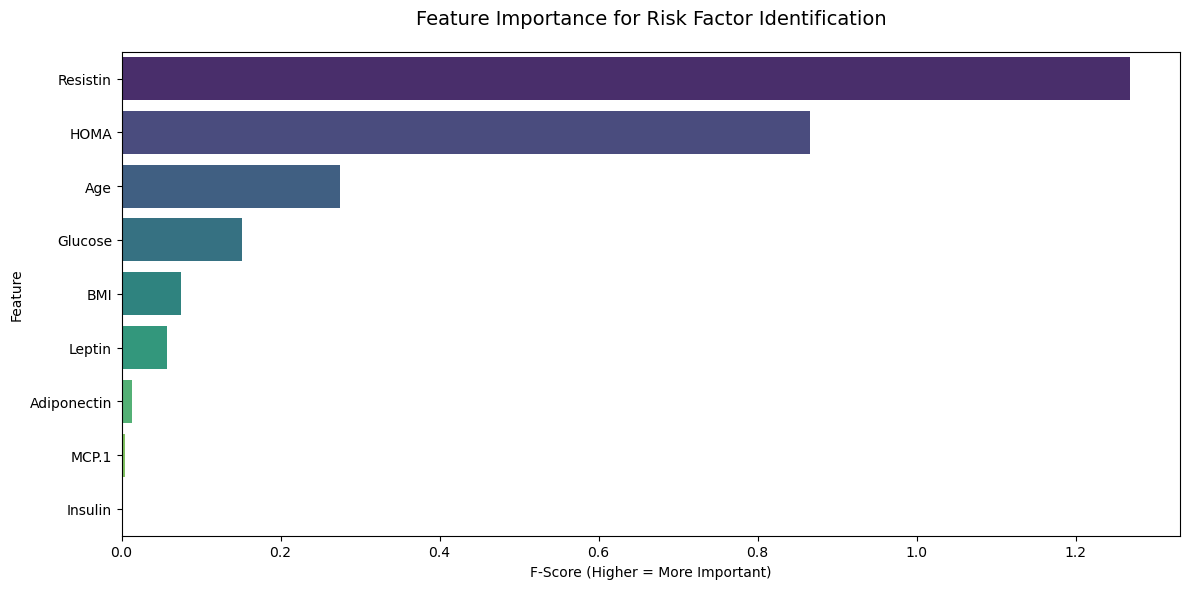

In [176]:
# Use ANOVA F-value for feature selection
selector = SelectKBest(score_func=f_classif, k='all')
selector.fit(X_train_scaled, y_train)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_names,
    'F_Score': selector.scores_,
    'P_Value': selector.pvalues_
}).sort_values('F_Score', ascending=False)

print("Feature Importance Scores (ANOVA F-value):")
for _, row in feature_scores.iterrows():
    significance = "***" if row['P_Value'] < 0.05 else "   "
    print(f"   {significance} {row['Feature']:15}: F={row['F_Score']:8.2f}, p={row['P_Value']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_scores, x='F_Score', y='Feature', palette='viridis')
plt.title('Feature Importance for Risk Factor Identification', fontsize=14, pad=20)
plt.xlabel('F-Score (Higher = More Important)')
plt.tight_layout()
plt.show()

# Feature Engineering for Risk Assessment

In [185]:
# Create additional features that might be clinically relevant
def create_risk_features(df):
    df_eng = df.copy()
    
    # Metabolic syndrome indicators
    df_eng['BMI_Category'] = np.where(df_eng['BMI'] > 30, 1, 0)  # Obesity indicator
    df_eng['High_Glucose'] = np.where(df_eng['Glucose'] > 100, 1, 0)  # Prediabetes indicator
    df_eng['High_Insulin'] = np.where(df_eng['Insulin'] > 25, 1, 0)  # Insulin resistance indicator
    
    # Hormonal ratios
    df_eng['Leptin_Adiponectin_Ratio'] = df_eng['Leptin'] / (df_eng['Adiponectin'] + 1e-6)
    df_eng['Inflammatory_Index'] = df_eng['Resistin'] * df_eng['MCP.1']
    
    return df_eng

# Apply feature engineering
X_train_eng = create_risk_features(X_train_scaled)
X_test_eng = create_risk_features(X_test_scaled)

print(f" Feature engineering completed:")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Engineered features: {X_train_eng.shape[1]}")
print(f"   New features: BMI_Category, High_Glucose, High_Insulin, Leptin_Adiponectin_Ratio, Inflammatory_Index")

 Feature engineering completed:
   Original features: 9
   Engineered features: 14
   New features: BMI_Category, High_Glucose, High_Insulin, Leptin_Adiponectin_Ratio, Inflammatory_Index


# Data Preparation Verification

In [194]:
print("\n DATA PREPARATION VERIFICATION")
print("="*35)

print(f" FINAL DATA SHAPES:")
print(f"   Training Features: {X_train_eng.shape}")
print(f"   Training Target: {y_train.shape}")
print(f"   Testing Features: {X_test_eng.shape}")
print(f"   Testing Target: {y_test.shape}")

print(f"\n DATA QUALITY CHECK:")
print(f"   Missing values: {X_train_eng.isnull().sum().sum() + X_test_eng.isnull().sum().sum()}")
print(f"   Infinite values: {np.isinf(X_train_eng).sum().sum() + np.isinf(X_test_eng).sum().sum()}")
print(f"   Data types consistent: {X_train_eng.dtypes.nunique() == 1}")

print(f"\n STATISTICAL CHECK:")
print(f"   Training mean: {X_train_eng.mean().mean():.3f}")
print(f"   Training std: {X_train_eng.std().mean():.3f}")
print(f"   Feature correlation range: {X_train_eng.corrwith(y_train).abs().min():.3f} - {X_train_eng.corrwith(y_train).abs().max():.3f}")


 DATA PREPARATION VERIFICATION
 FINAL DATA SHAPES:
   Training Features: (2800, 14)
   Training Target: (2800,)
   Testing Features: (1200, 14)
   Testing Target: (1200,)

 DATA QUALITY CHECK:
   Missing values: 0
   Infinite values: 0
   Data types consistent: False

 STATISTICAL CHECK:
   Training mean: -0.001
   Training std: 6.961
   Feature correlation range: 0.000 - 0.033


# Save Prepared Data

In [201]:
# Create final prepared dataset dictionary
clinical_prepared_data = {
    'X_train': X_train_eng,
    'X_test': X_test_eng,
    'y_train': y_train,
    'y_test': y_test,
    'feature_names': X_train_eng.columns.tolist(),
    'scaler': scaler,
    'feature_importance': feature_scores,
    'original_shapes': {
        'original': clinical_df.shape,
        'training': X_train_eng.shape,
        'testing': X_test_eng.shape
    }
}

print(f"\n CLINICAL DATA PREPARED SUCCESSFULLY!")
print("="*40)

print(f" PREPARED FOR: Risk Factor Identification in Healthy Patients")
print(f" Dataset: {clinical_prepared_data['original_shapes']['original'][0]} samples")
print(f" Features: {clinical_prepared_data['original_shapes']['training'][1]} (including engineered features)")
print(f" Split: {clinical_prepared_data['original_shapes']['training'][0]} train, {clinical_prepared_data['original_shapes']['testing'][0]} test")
print(f" Balance: {(y_train== 1).sum()/len(y_train)*100:.1f}% patients in training")


 CLINICAL DATA PREPARED SUCCESSFULLY!
 PREPARED FOR: Risk Factor Identification in Healthy Patients
 Dataset: 4000 samples
 Features: 14 (including engineered features)
 Split: 2800 train, 1200 test
 Balance: 55.4% patients in training


# Final Visualization

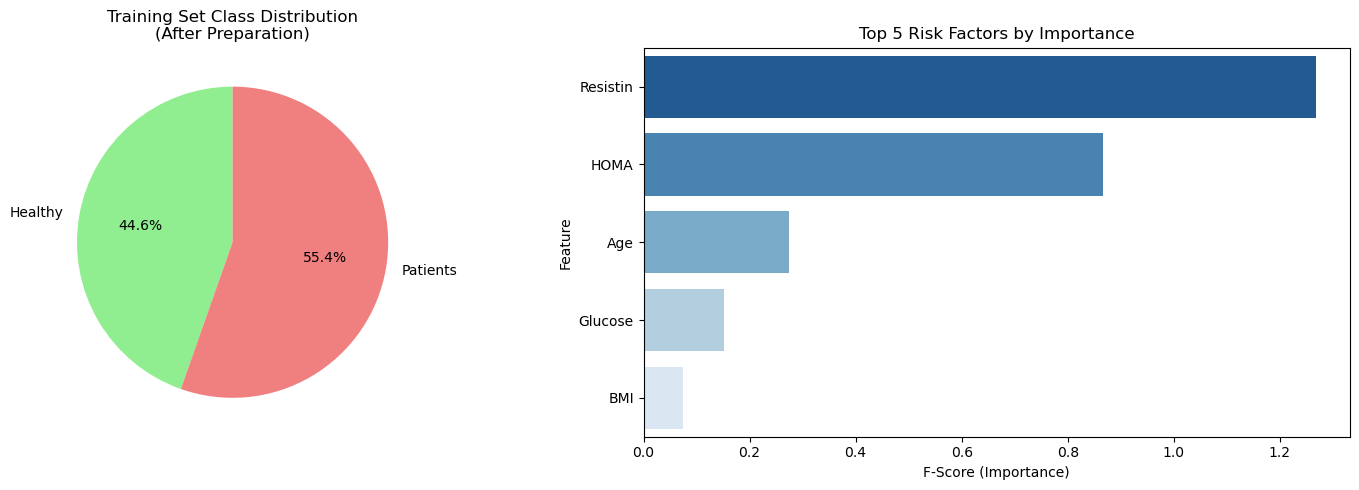

In [206]:
# Final visualization of prepared data
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Class distribution
class_counts = [len(y_train) - y_train.sum(), y_train.sum()]
axes[0].pie(class_counts, labels=['Healthy', 'Patients'], autopct='%1.1f%%', 
           colors=['lightgreen', 'lightcoral'], startangle=90)
axes[0].set_title('Training Set Class Distribution\n(After Preparation)')

# Top 5 most important features
top_features = feature_scores.head(5)
sns.barplot(data=top_features, x='F_Score', y='Feature', ax=axes[1], palette='Blues_r')
axes[1].set_title('Top 5 Risk Factors by Importance')
axes[1].set_xlabel('F-Score (Importance)')

plt.tight_layout()
plt.show()

### 3.3 Data preparation - Data images

In [ ]:
#datasets des images
IMG_SIZE = 50 

#maps filename to actual image data
def load_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)  # scales to [0,1]
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((df_train_images["filename"], df_train_images["label"]))
train_ds = train_ds.map(load_preprocess).shuffle(5000).batch(64).prefetch(1) #shuffle pour rendre les images aleatoires chaque epoch

val_ds = tf.data.Dataset.from_tensor_slices((df_val_images["filename"], df_val_images["label"]))
val_ds = val_ds.map(load_preprocess).batch(64).prefetch(1)

test_ds = tf.data.Dataset.from_tensor_slices((df_test_images["filename"], df_test_images["label"]))
test_ds = test_ds.map(load_preprocess).batch(64).prefetch(1)

# 4. Modeling DSO 1

# 4.1 Algorithme 1 : Linear Regression

In [48]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

print("=== LINEAR REGRESSION - TensorFlow Optimized ===")
print("="*55)

# Données
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.reshape(-1, 1).astype(np.float32)
y_test = prepared_data['y_test'].values.reshape(-1, 1).astype(np.float32)

# Paramètres exacts de l'article (Table 1)
batch_size = 128
epochs = 3000
learning_rate = 1e-3

print(f" Hyperparameters:")
print(f"   • Batch Size: {batch_size}")
print(f"   • Epochs: {epochs}")
print(f"   • Learning Rate: {learning_rate}")
print(f"   • Threshold: 0.5")

# Modèle
W = tf.Variable(tf.random.normal([X_train.shape[1], 1], stddev=0.01))
b = tf.Variable(tf.zeros([1]))

def linear_model(X):
    return tf.matmul(X, W) + b

def predict_class(X, threshold=0.5):
    return tf.cast(linear_model(X) >= threshold, tf.float32)

# Fonction de perte MSE (Equation 9 dans l'article)
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Optimiseur SGD
optimizer = tf.optimizers.SGD(learning_rate)

# Variables pour l'historique
train_acc_history = []
test_acc_history = []
loss_history = []

print(f"\n Training...")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")

# Calcul du nombre total de data points (comme dans l'article)
n_batches = int(np.ceil(len(X_train) / batch_size))
total_data_points = epochs * batch_size * n_batches

# Entraînement
for epoch in range(epochs):
    epoch_loss = 0
    
    # Mélanger les données
    indices = np.random.permutation(len(X_train))
    X_shuffled = X_train[indices]
    y_shuffled = y_train[indices]
    
    # Batch training
    for i in range(0, len(X_train), batch_size):
        batch_X = X_shuffled[i:i+batch_size]
        batch_y = y_shuffled[i:i+batch_size]
        
        with tf.GradientTape() as tape:
            y_pred = linear_model(batch_X)
            loss_value = mse_loss(batch_y, y_pred)
        
        grads = tape.gradient(loss_value, [W, b])
        optimizer.apply_gradients(zip(grads, [W, b]))
        
        epoch_loss += loss_value.numpy()
    
    # Moyenne de la perte pour l'epoch
    avg_loss = epoch_loss / n_batches
    loss_history.append(avg_loss)
    
    # Calcul de l'accuracy tous les 500 epochs
    if (epoch + 1) % 500 == 0:
        # Accuracy sur training
        train_preds = predict_class(X_train).numpy()
        train_acc = np.mean(train_preds == y_train)
        train_acc_history.append(train_acc)
        
        # Accuracy sur test
        test_preds = predict_class(X_test).numpy()
        test_acc = np.mean(test_preds == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{epochs} - Loss: {avg_loss:.6f} - Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

print(f"\n Training completed!")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {loss_history[-1]:.6f}")

=== LINEAR REGRESSION - TensorFlow Optimized ===
 Hyperparameters:
   • Batch Size: 128
   • Epochs: 3000
   • Learning Rate: 0.001
   • Threshold: 0.5

 Training...
   Training samples: 398
   Testing samples: 171
   Epoch  500/3000 - Loss: 0.062790 - Train Acc: 0.9573 - Test Acc: 0.9415
   Epoch 1000/3000 - Loss: 0.051775 - Train Acc: 0.9648 - Test Acc: 0.9591
   Epoch 1500/3000 - Loss: 0.057336 - Train Acc: 0.9623 - Test Acc: 0.9649
   Epoch 2000/3000 - Loss: 0.048995 - Train Acc: 0.9648 - Test Acc: 0.9649
   Epoch 2500/3000 - Loss: 0.056932 - Train Acc: 0.9648 - Test Acc: 0.9708
   Epoch 3000/3000 - Loss: 0.053982 - Train Acc: 0.9648 - Test Acc: 0.9649

 Training completed!
   Total data points processed: 1536000
   Final training loss: 0.053982


# 4.2 Algorithme 2 : Neighbor Classification

In [54]:
import numpy as np
import time
from collections import Counter

print("=== NEAREST NEIGHBOR - Geometric Approach (k=1) ===")
print("="*60)

# Dataset
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")

# Fonctions de distance (comme dans l'article, Eq. 12 et 13)
def manhattan_distance(a, b):
    """L1 distance (Manhattan) - Eq. 12"""
    return np.sum(np.abs(a - b), axis=1)

def euclidean_distance(a, b):
    """L2 distance (Euclidean) - Eq. 13"""
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

# Fonction de prédiction k=1 (Nearest Neighbor)
def nearest_neighbor_predict(X_train, y_train, X_test, norm='L2'):
    """
    Nearest Neighbor (k=1) implementation
    norm: 'L1' for Manhattan, 'L2' for Euclidean
    """
    predictions = []
    
    for i in range(len(X_test)):
        test_point = X_test[i]
        
        # Calcul des distances
        if norm == 'L1':
            distances = manhattan_distance(X_train, test_point)
        else:  # L2
            distances = euclidean_distance(X_train, test_point)
        
        # Trouver l'indice du plus proche voisin (k=1)
        nearest_idx = np.argmin(distances)
        
        # Récupérer le label du plus proche voisin
        prediction = y_train[nearest_idx]
        predictions.append(prediction)
    
    return np.array(predictions)

print(f"\n Modeling Information:")
print(f"   Algorithm: Nearest Neighbor (k=1)")
print(f"   Distance metrics: L1 (Manhattan) and L2 (Euclidean)")
print(f"   No training required - geometric approach")

=== NEAREST NEIGHBOR - Geometric Approach (k=1) ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30

 Modeling Information:
   Algorithm: Nearest Neighbor (k=1)
   Distance metrics: L1 (Manhattan) and L2 (Euclidean)
   No training required - geometric approach


# 4.3 Algorithme 3 : Softmax Regression

In [72]:
import tensorflow as tf
import numpy as np
import time

print("=== SOFTMAX REGRESSION - MODELING PHASE ===")
print("="*65)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

# Convert labels to one-hot encoding for softmax
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification)")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'epochs': 3000
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Model parameters
input_dim = X_train.shape[1]
output_dim = 2  # Binary classification

print(f"\n Building Softmax Regression model...")

# Initialize weights and biases
W = tf.Variable(tf.random.normal([input_dim, output_dim], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([output_dim]), name='bias')

# Softmax function
def softmax_model(X):
    logits = tf.matmul(X, W) + b
    return tf.nn.softmax(logits)

# Cross-entropy loss function (Equation 15 in the article)
def cross_entropy_loss(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = tf.clip_by_value(y_pred, 1e-10, 1.0)
    return -tf.reduce_mean(tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Predict class from probabilities
def predict_class(y_pred_proba):
    return tf.argmax(y_pred_proba, axis=1)

# Optimizer (SGD as in the article)
optimizer = tf.optimizers.SGD(learning_rate=hyperparams['learning_rate'])

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_onehot[indices]
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            y_pred_proba = softmax_model(batch_X)
            loss = cross_entropy_loss(batch_y, y_pred_proba)
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(gradients, [W, b]))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred_proba = softmax_model(X_train)
        train_pred = predict_class(train_pred_proba).numpy()
        train_acc = np.mean(train_pred == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred_proba = softmax_model(X_test)
        test_pred = predict_class(test_pred_proba).numpy()
        test_acc = np.mean(test_pred == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   Model ready for evaluation.")

=== SOFTMAX REGRESSION - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification)

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   learning_rate: 0.001
   epochs: 3000

 Building Softmax Regression model...

 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 0.651041 - Train Acc: 0.8970 - Test Acc: 0.9181
   Epoch  500/3000 - Loss: 0.149038 - Train Acc: 0.9698 - Test Acc: 0.9708
   Epoch 1000/3000 - Loss: 0.113463 - Train Acc: 0.9774 - Test Acc: 0.9766
   Epoch 1500/3000 - Loss: 0.127365 - Train Acc: 0.9774 - Test Acc: 0.9883
   Epoch 2000/3000 - Loss: 0.115689 - Train Acc: 0.9749 - Test Acc: 0.9883
   Epoch 2500/3000 - Loss: 0.092263 - Train Acc: 0.9799 - Test Acc: 0.9883
   Epoch 3000/3000 - Loss: 0.081253 - Train Acc: 0.9799 - Test Acc: 0.9883

 Training completed!
   Training time: 70.99 seconds
   Total data po

# 4.4 Algorithme 4 : Support Vector Machine (SVM)

In [82]:
import tensorflow as tf
import numpy as np
import time

print("=== SUPPORT VECTOR MACHINE (SVM) - MODELING PHASE ===")
print("="*70)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.float32)
y_test = prepared_data['y_test'].values.astype(np.float32)

# Convert labels from {0, 1} to {-1, 1} for SVM
y_train_svm = 2 * y_train - 1
y_test_svm = 2 * y_test - 1

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification with labels -1, 1)")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'epochs': 3000,
    'C': 5,          # SVM penalty parameter (Table 1: SVM C=5)
    'norm': 'L2'     # L2 norm for SVM (Table 1: Norm=L2)
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Model parameters
input_dim = X_train.shape[1]

print(f"\n Building L2-SVM model (Equation 20 in article)...")

# Initialize weights and bias for SVM: decision function = sign(w·x + b)
W = tf.Variable(tf.random.normal([input_dim, 1], stddev=0.01), name='weights')
b = tf.Variable(tf.zeros([1]), name='bias')

# L2-SVM loss function (Equation 20 in the article)
def l2_svm_loss(X, y, W, b, C):
    """
    L2-SVM loss: 0.5 * ||w||² + C * Σ max(0, 1 - y_i*(w·x_i + b))²
    Equation 20 in article: min 1/p * ||w||₂² + C * Σ max(0, 1 - y_i'(w_i·x_i + b))²
    """
    # Regularization term: 0.5 * ||w||² (scaled by 1/p in article, but we'll use 0.5)
    reg_term = 0.5 * tf.reduce_sum(tf.square(W))
    
    # Hinge loss term with squared hinge (L2-SVM)
    scores = tf.matmul(X, W) + b
    hinge_loss = tf.maximum(0.0, 1.0 - y * scores)
    hinge_loss_squared = tf.square(hinge_loss)
    
    # Total loss: regularization + C * average squared hinge loss
    total_loss = reg_term + C * tf.reduce_mean(hinge_loss_squared)
    return total_loss

# Predict function for SVM
def svm_predict(X):
    scores = tf.matmul(X, W) + b
    return tf.sign(scores)

# Optimizer (Adam as mentioned in the article for SVM, section 2.4.1)
optimizer = tf.optimizers.Adam(learning_rate=hyperparams['learning_rate'])

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_svm[indices].reshape(-1, 1)
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Compute L2-SVM loss
            loss = l2_svm_loss(batch_X, batch_y, W, b, hyperparams['C'])
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, [W, b])
        optimizer.apply_gradients(zip(gradients, [W, b]))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred = svm_predict(X_train).numpy()
        train_pred_binary = (train_pred > 0).astype(np.float32)
        train_acc = np.mean(train_pred_binary.reshape(-1) == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred = svm_predict(X_test).numpy()
        test_pred_binary = (test_pred > 0).astype(np.float32)
        test_acc = np.mean(test_pred_binary.reshape(-1) == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   SVM model ready for evaluation.")

=== SUPPORT VECTOR MACHINE (SVM) - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification with labels -1, 1)

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   learning_rate: 0.001
   epochs: 3000
   C: 5
   norm: L2

 Building L2-SVM model (Equation 20 in article)...

 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 5.045914 - Train Acc: 0.7965 - Test Acc: 0.7895
   Epoch  500/3000 - Loss: 0.707852 - Train Acc: 0.9824 - Test Acc: 0.9825
   Epoch 1000/3000 - Loss: 1.046495 - Train Acc: 0.9824 - Test Acc: 0.9825
   Epoch 1500/3000 - Loss: 0.679556 - Train Acc: 0.9824 - Test Acc: 0.9825
   Epoch 2000/3000 - Loss: 0.685342 - Train Acc: 0.9824 - Test Acc: 0.9766
   Epoch 2500/3000 - Loss: 0.746809 - Train Acc: 0.9824 - Test Acc: 0.9825
   Epoch 3000/3000 - Loss: 0.640493 - Train Acc: 0.9824 - Test Acc: 0.9825

 Trainin

# 4.5 Algorithme 5 : Multilayer Perceptron (MLP)

In [63]:
import tensorflow as tf
import numpy as np
import time

print("=== MULTILAYER PERCEPTRON (MLP) - MODELING PHASE ===")
print("="*70)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.int32)
y_test = prepared_data['y_test'].values.astype(np.int32)

# Convert labels to one-hot encoding
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=2)

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Classes: 2 (Binary classification)")

# Hyperparameters EXACTLY as in Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'learning_rate': 1e-2,
    'epochs': 3000,
    'hidden_layers': [500, 500, 500],  # 500-500-500 architecture
    'activation': 'ReLU',
    'output_activation': 'softmax',
    'loss_function': 'cross_entropy'
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Learning rate: {hyperparams['learning_rate']}")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Architecture: {hyperparams['hidden_layers']}")
print(f"   Activation: {hyperparams['activation']}")

# Model parameters
input_dim = X_train.shape[1]
output_dim = 2

print(f"\n Building MLP model with 3 hidden layers (500-500-500)...")

# Build MLP model using Keras Sequential API
def build_mlp_model(input_dim, hidden_layers, output_dim=2):
    model = tf.keras.Sequential()
    
    # Input layer
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))
    
    # Hidden layers with ReLU activation (as in article)
    for units in hidden_layers:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    
    # Output layer with softmax activation for binary classification
    model.add(tf.keras.layers.Dense(output_dim, activation='softmax'))
    
    return model

# Create model
mlp_model = build_mlp_model(input_dim, hyperparams['hidden_layers'], output_dim)

# Compile model with SGD optimizer (EXACTLY as in the article)
optimizer = tf.keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'])
mlp_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',  # Cross-entropy loss (Equation 15)
    metrics=['accuracy']
)

# Print model summary
print(f"\n Model Architecture:")
mlp_model.summary()

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")
print(f"   Total batches per epoch: {n_batches}")

# Training history
train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (EXACTLY as in article - 3000 epochs with SGD)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train[indices]
    y_shuffled = y_train_onehot[indices]
    
    # Mini-batch training (SGD)
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = mlp_model(batch_X, training=True)
            loss = tf.keras.losses.categorical_crossentropy(batch_y, predictions)
            loss = tf.reduce_mean(loss)
        
        # Compute gradients and update weights (SGD)
        gradients = tape.gradient(loss, mlp_model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, mlp_model.trainable_variables))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred_proba = mlp_model.predict(X_train, verbose=0)
        train_pred = np.argmax(train_pred_proba, axis=1)
        train_acc = np.mean(train_pred == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred_proba = mlp_model.predict(X_test, verbose=0)
        test_pred = np.argmax(test_pred_proba, axis=1)
        test_acc = np.mean(test_pred == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed (as in article)
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")

# Save the trained model for evaluation
print(f"\n Model saved for evaluation phase.")

=== MULTILAYER PERCEPTRON (MLP) - MODELING PHASE ===
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30
   Classes: 2 (Binary classification)

 Hyperparameters (Table 1 - Exact from article):
   Batch size: 128
   Learning rate: 0.01
   Epochs: 3000
   Architecture: [500, 500, 500]
   Activation: ReLU

 Building MLP model with 3 hidden layers (500-500-500)...

 Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                      │ (None, 500)                 │          15,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 500)                 │         250,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 2)                   │           1,002 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 517,502 (1.97 MB)

 Trainable params: 517,502 (1.97 MB)

 Non-trainable params: 0 (0.00 B)


 Starting training...
   Epochs: 3000
   Batch size: 128
   Total batches per epoch: 4
   Epoch    1/3000 - Loss: 0.720119 - Train Acc: 0.3744 - Test Acc: 0.3801
   Epoch  500/3000 - Loss: 0.017352 - Train Acc: 0.9950 - Test Acc: 0.9766
   Epoch 1000/3000 - Loss: 0.005291 - Train Acc: 1.0000 - Test Acc: 0.9766
   Epoch 1500/3000 - Loss: 0.002541 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 2000/3000 - Loss: 0.002206 - Train Acc: 1.0000 - Test Acc: 0.9708
   Epoch 2500/3000 - Loss: 0.001648 - Train Acc: 1.0000 - Test Acc: 0.9649
   Epoch 3000/3000 - Loss: 0.000722 - Train Acc: 1.0000 - Test Acc: 0.9649

 Training completed!
   Training time: 304.71 seconds
   Total data points processed: 1536000
   Final training loss: 0.000722

 Model saved for evaluation phase.


# 4.6 Algorithme 6 : GRU-SVM

In [87]:
import tensorflow as tf
import numpy as np
import time

print("=== GRU-SVM - MODELING PHASE ===")
print("="*60)
print("Combining Gated Recurrent Unit (GRU) with Support Vector Machine (SVM)")
print("="*60)

# Data
X_train = prepared_data['X_train'].values.astype(np.float32)
X_test = prepared_data['X_test'].values.astype(np.float32)
y_train = prepared_data['y_train'].values.astype(np.float32)
y_test = prepared_data['y_test'].values.astype(np.float32)

# Convert labels from {0, 1} to {-1, 1} for SVM
y_train_svm = 2 * y_train - 1
y_test_svm = 2 * y_test - 1

print(f" Dataset Information:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Testing samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")

# Hyperparameters EXACTLY from Table 1 of the article
hyperparams = {
    'batch_size': 128,
    'cell_size': 128,      # Table 1: Cell Size = 128
    'dropout_rate': 0.5,   # Table 1: Dropout Rate = 0.5
    'epochs': 3000,
    'learning_rate': 1e-3,
    'svm_c': 5            # Table 1: SVM C = 5
}

print(f"\n Hyperparameters (Table 1 - Exact from article):")
for key, value in hyperparams.items():
    print(f"   {key}: {value}")

# Reshape data for GRU (batch_size, time_steps=1, features=30)
# We treat each sample as a sequence of 1 time step with 30 features
X_train_reshaped = X_train.reshape(-1, 1, X_train.shape[1])
X_test_reshaped = X_test.reshape(-1, 1, X_test.shape[1])

print(f"\n Data reshaped for GRU: {X_train_reshaped.shape}")
print(f"   Format: (samples, time_steps=1, features=30)")

print(f"\n Building GRU-SVM model (as in article section 2.4.1)...")

# GRU-SVM Model (following equations 2-5 from the article)
class GRUSVMModel(tf.keras.Model):
    def __init__(self, cell_size, dropout_rate, svm_c):
        super(GRUSVMModel, self).__init__()
        
        # GRU Layer (Gated Recurrent Unit)
        self.gru = tf.keras.layers.GRU(
            units=cell_size,
            return_sequences=False,
            dropout=dropout_rate,
            recurrent_dropout=dropout_rate
        )
        
        # Dropout layer
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        # SVM layer (Dense layer with linear activation)
        self.svm_layer = tf.keras.layers.Dense(1, activation=None)
        
        # SVM parameter C
        self.svm_c = svm_c
        
    def call(self, inputs, training=False):
        # GRU processing (Equations 2-5 in article)
        gru_output = self.gru(inputs, training=training)
        
        # Dropout
        dropped = self.dropout(gru_output, training=training)
        
        # SVM prediction (sign(wx + b) as in article)
        svm_output = self.svm_layer(dropped)
        
        return svm_output
    
    def svm_loss(self, y_true, y_pred):
        """L2-SVM loss function (Equation 20 from the article)"""
        # Regularization term: 0.5 * ||w||²
        reg_term = 0.5 * tf.reduce_sum([tf.reduce_sum(tf.square(w)) 
                                        for w in self.trainable_variables 
                                        if 'kernel' in w.name])
        
        # Hinge loss with L2 penalty (squared hinge)
        hinge_loss = tf.maximum(0.0, 1.0 - y_true * y_pred)
        hinge_loss_squared = tf.square(hinge_loss)
        
        # Total loss: 0.5*||w||² + C * Σ max(0, 1 - y_i*(w·x_i + b))²
        total_loss = reg_term + self.svm_c * tf.reduce_mean(hinge_loss_squared)
        
        return total_loss

# Create GRU-SVM model
model = GRUSVMModel(
    cell_size=hyperparams['cell_size'],
    dropout_rate=hyperparams['dropout_rate'],
    svm_c=hyperparams['svm_c']
)

# Build the model
model.build(input_shape=(None, 1, X_train.shape[1]))
model.summary()

# Optimizer (Adam as mentioned in the article, section 2.4.1)
optimizer = tf.keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])

print(f"\n Starting training...")
print(f"   Epochs: {hyperparams['epochs']}")
print(f"   Batch size: {hyperparams['batch_size']}")

# Training variables
n_samples = X_train.shape[0]
n_batches = int(np.ceil(n_samples / hyperparams['batch_size']))

train_loss_history = []
train_acc_history = []
test_acc_history = []

start_time = time.time()

# Training loop (3000 epochs as in Table 1)
for epoch in range(hyperparams['epochs']):
    epoch_loss = 0
    
    # Shuffle data each epoch
    indices = np.random.permutation(n_samples)
    X_shuffled = X_train_reshaped[indices]
    y_shuffled = y_train_svm[indices].reshape(-1, 1)
    
    # Mini-batch training
    for batch in range(n_batches):
        start_idx = batch * hyperparams['batch_size']
        end_idx = min((batch + 1) * hyperparams['batch_size'], n_samples)
        
        batch_X = X_shuffled[start_idx:end_idx]
        batch_y = y_shuffled[start_idx:end_idx]
        
        with tf.GradientTape() as tape:
            # Forward pass
            predictions = model(batch_X, training=True)
            loss = model.svm_loss(batch_y, predictions)
        
        # Compute gradients and update weights
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        epoch_loss += loss.numpy()
    
    # Average loss for the epoch
    avg_loss = epoch_loss / n_batches
    train_loss_history.append(avg_loss)
    
    # Calculate accuracy every 500 epochs
    if (epoch + 1) % 500 == 0 or epoch == 0:
        # Training accuracy
        train_pred = model(X_train_reshaped, training=False).numpy()
        train_pred_binary = (train_pred > 0).astype(np.float32)
        train_acc = np.mean(train_pred_binary.reshape(-1) == y_train)
        train_acc_history.append(train_acc)
        
        # Testing accuracy
        test_pred = model(X_test_reshaped, training=False).numpy()
        test_pred_binary = (test_pred > 0).astype(np.float32)
        test_acc = np.mean(test_pred_binary.reshape(-1) == y_test)
        test_acc_history.append(test_acc)
        
        print(f"   Epoch {epoch+1:4d}/{hyperparams['epochs']} - Loss: {avg_loss:.6f} - "
              f"Train Acc: {train_acc:.4f} - Test Acc: {test_acc:.4f}")

training_time = time.time() - start_time

# Calculate total data points processed
total_data_points = hyperparams['epochs'] * hyperparams['batch_size'] * n_batches

print(f"\n Training completed!")
print(f"   Training time: {training_time:.2f} seconds")
print(f"   Total data points processed: {total_data_points}")
print(f"   Final training loss: {train_loss_history[-1]:.6f}")
print(f"   GRU-SVM model ready for evaluation.")

=== GRU-SVM - MODELING PHASE ===
Combining Gated Recurrent Unit (GRU) with Support Vector Machine (SVM)
 Dataset Information:
   Training samples: 398
   Testing samples: 171
   Features: 30

 Hyperparameters (Table 1 - Exact from article):
   batch_size: 128
   cell_size: 128
   dropout_rate: 0.5
   epochs: 3000
   learning_rate: 0.001
   svm_c: 5

 Data reshaped for GRU: (398, 1, 30)
   Format: (samples, time_steps=1, features=30)

 Building GRU-SVM model (as in article section 2.4.1)...


Model: "grusvm_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


 Starting training...
   Epochs: 3000
   Batch size: 128
   Epoch    1/3000 - Loss: 93.496618 - Train Acc: 0.9070 - Test Acc: 0.9181
   Epoch  500/3000 - Loss: 1.464562 - Train Acc: 0.9648 - Test Acc: 0.9474
   Epoch 1000/3000 - Loss: 1.228373 - Train Acc: 0.9673 - Test Acc: 0.9532
   Epoch 1500/3000 - Loss: 1.497088 - Train Acc: 0.9598 - Test Acc: 0.9532
   Epoch 2000/3000 - Loss: 1.179880 - Train Acc: 0.9698 - Test Acc: 0.9649
   Epoch 2500/3000 - Loss: 1.781058 - Train Acc: 0.9673 - Test Acc: 0.9591
   Epoch 3000/3000 - Loss: 1.333430 - Train Acc: 0.9724 - Test Acc: 0.9649

 Training completed!
   Training time: 924.35 seconds
   Total data points processed: 1536000
   Final training loss: 1.333430
   GRU-SVM model ready for evaluation.


# 5. Evaluation DSO1

# 5.1 Evaluation algorithme 1 : Linear Regression

In [52]:
print("\n" + "="*55)
print("EVALUATION PHASE")
print("="*55)

# Évaluation finale
print(f"\n Final Evaluation:")

# Prédictions finales
final_preds = predict_class(X_test).numpy()
final_accuracy = np.mean(final_preds == y_test)

# Calcul des métriques détaillées
cm = confusion_matrix(y_test, final_preds)
tn, fp, fn, tp = cm.ravel()

# Calcul des métriques comme dans l'article
fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparaison avec les résultats de l'article
print(f"\n" + "="*55)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*55)

article_results = {
    'Accuracy': 0.9609375,
    'FPR': 0.10204082,
    'FNR': 0.0,
    'TPR': 1.0,
    'TNR': 0.89795918,
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': epochs
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>6.4f}%{'':<8} {article_val*100:>6.4f}%{'':<8} {diff*100:>+7.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>7.6f}    {article_val:>7.6f}    {diff:>+7.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {epochs:>15} {article_results['Epochs']:>15} {epochs - article_results['Epochs']:>+15}")

# Conclusion
print(f"\n" + "="*55)
print("CONCLUSION")
print("="*55)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100
if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Linear Regression Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Sauvegarde des résultats pour comparaison finale
linear_regression_results = {
    'model': 'Linear Regression',
    'accuracy': final_accuracy,
    'fpr': fpr,
    'fnr': fnr,
    'tpr': tpr,
    'tnr': tnr,
    'data_points': total_data_points,
    'confusion_matrix': cm.tolist(),
    'better_than_article': final_accuracy > article_results['Accuracy'],
    'accuracy_diff_percent': accuracy_diff
}

print(f"\n Results saved for final comparison with other algorithms.")


EVALUATION PHASE

 Final Evaluation:

 Performance Metrics:
   Accuracy: 96.491228% (0.964912)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 9.375000% (0.093750)
   TPR (True Positive Rate): 90.625000% (0.906250)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            6             58

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             96.4912%         96.0938%         +0.3975%
   FPR                  0.000000    0.102041    -0.102041
   FNR                  0.093750    0.000000    +0.093750
   TPR                  0.906250    1.000000    -0.093750
   TNR                  1.000000    0.897959    +0.102041

   Data Points                  1536000          384000        +115200

# 5.2 Evaluation algorithme 2 : Neighbor Classification

In [57]:
print("\n" + "="*60)
print("EVALUATION PHASE")
print("="*60)

# Fonction pour calculer toutes les métriques
def calculate_metrics(y_true, y_pred):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    return accuracy, fpr, fnr, tpr, tnr, cm

# --- L1 Manhattan (k=1) ---
print(f"\n L1 (Manhattan) Distance - k=1...")
start_time = time.time()

y_pred_l1 = nearest_neighbor_predict(X_train, y_train, X_test, norm='L1')
time_l1 = time.time() - start_time

acc_l1, fpr_l1, fnr_l1, tpr_l1, tnr_l1, cm_l1 = calculate_metrics(y_test, y_pred_l1)

print(f" L1 Results (Manhattan - k=1):")
print(f"   Accuracy: {acc_l1*100:.6f}%")
print(f"   Computation time: {time_l1:.2f} seconds")
print(f"   Data points processed: {len(X_test)}")

# --- L2 Euclidean (k=1) ---
print(f"\n L2 (Euclidean) Distance - k=1...")
start_time = time.time()

y_pred_l2 = nearest_neighbor_predict(X_train, y_train, X_test, norm='L2')
time_l2 = time.time() - start_time

acc_l2, fpr_l2, fnr_l2, tpr_l2, tnr_l2, cm_l2 = calculate_metrics(y_test, y_pred_l2)

print(f" L2 Results (Euclidean - k=1):")
print(f"   Accuracy: {acc_l2*100:.6f}%")
print(f"   Computation time: {time_l2:.2f} seconds")
print(f"   Data points processed: {len(X_test)}")

# Comparaison avec les résultats de l'article (k=1)
print(f"\n" + "="*60)
print("COMPARISON WITH ARTICLE RESULTS (Table 2) - k=1")
print("="*60)

article_results = {
    'L1': {
        'accuracy': 0.93567252,      # 93.567252%
        'fpr': 0.0625,               # 6.25%
        'fnr': 0.06542056,           # 6.542056%
        'tpr': 0.93457944,           # 93.457944%
        'tnr': 0.9375,               # 93.75%
        'data_points': 171,
        'epochs': 1
    },
    'L2': {
        'accuracy': 0.94736844,      # 94.736844%
        'fpr': 0.09375,              # 9.375%
        'fnr': 0.02803738,           # 2.803738%
        'tpr': 0.97196262,           # 97.196262%
        'tnr': 0.90625,              # 90.625%
        'data_points': 171,
        'epochs': 1
    }
}

# --- L1 Comparison ---
print(f"\n L1 (Manhattan) - k=1 - Detailed Comparison:")
print(f"{'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric, our_val, article_val in [
    ('Accuracy', acc_l1, article_results['L1']['accuracy']),
    ('FPR', fpr_l1, article_results['L1']['fpr']),
    ('FNR', fnr_l1, article_results['L1']['fnr']),
    ('TPR', tpr_l1, article_results['L1']['tpr']),
    ('TNR', tnr_l1, article_results['L1']['tnr'])
]:
    diff = our_val - article_val
    if metric == 'Accuracy':
        print(f"{metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"{metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

# --- L2 Comparison ---
print(f"\n L2 (Euclidean) - k=1 - Detailed Comparison:")
print(f"{'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"{'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric, our_val, article_val in [
    ('Accuracy', acc_l2, article_results['L2']['accuracy']),
    ('FPR', fpr_l2, article_results['L2']['fpr']),
    ('FNR', fnr_l2, article_results['L2']['fnr']),
    ('TPR', tpr_l2, article_results['L2']['tpr']),
    ('TNR', tnr_l2, article_results['L2']['tnr'])
]:
    diff = our_val - article_val
    if metric == 'Accuracy':
        print(f"{metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"{metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

# Matrices de confusion
print(f"\n" + "="*60)
print("CONFUSION MATRICES - k=1")
print("="*60)

print(f"\nL1 (Manhattan) - k=1:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {cm_l1[0,0]:6d}         {cm_l1[0,1]:6d}")
print(f"   Actual 1       {cm_l1[1,0]:6d}         {cm_l1[1,1]:6d}")

print(f"\nL2 (Euclidean) - k=1:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {cm_l2[0,0]:6d}         {cm_l2[0,1]:6d}")
print(f"   Actual 1       {cm_l2[1,0]:6d}         {cm_l2[1,1]:6d}")

# Conclusion
print(f"\n" + "="*60)
print("CONCLUSION")
print("="*60)

accuracy_diff_l1 = (acc_l1 - article_results['L1']['accuracy']) * 100
accuracy_diff_l2 = (acc_l2 - article_results['L2']['accuracy']) * 100

print(f"\n Nearest Neighbor Results (k=1):")

if accuracy_diff_l1 > 0:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  BETTER than article by {accuracy_diff_l1:+.4f}%")
elif accuracy_diff_l1 < 0:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  WORSE than article by {abs(accuracy_diff_l1):.4f}%")
else:
    print(f"   L1 (Manhattan):  {acc_l1*100:.4f}% -  MATCHES article")

if accuracy_diff_l2 > 0:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  BETTER than article by {accuracy_diff_l2:+.4f}%")
elif accuracy_diff_l2 < 0:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  WORSE than article by {abs(accuracy_diff_l2):.4f}%")
else:
    print(f"   L2 (Euclidean):  {acc_l2*100:.4f}% -  MATCHES article")

# Sauvegarde des résultats
nearest_neighbor_results = {
    'L1': {
        'model': 'Nearest Neighbor (L1 - Manhattan, k=1)',
        'k': 1,
        'norm': 'L1',
        'performance': {
            'accuracy': float(acc_l1),
            'fpr': float(fpr_l1),
            'fnr': float(fnr_l1),
            'tpr': float(tpr_l1),
            'tnr': float(tnr_l1),
            'data_points': len(X_test),
            'epochs': 1,
            'computation_time': time_l1,
            'confusion_matrix': cm_l1.tolist()
        },
        'comparison': {
            'accuracy_diff': float(acc_l1 - article_results['L1']['accuracy']),
            'better_than_article': acc_l1 > article_results['L1']['accuracy']
        }
    },
    'L2': {
        'model': 'Nearest Neighbor (L2 - Euclidean, k=1)',
        'k': 1,
        'norm': 'L2',
        'performance': {
            'accuracy': float(acc_l2),
            'fpr': float(fpr_l2),
            'fnr': float(fnr_l2),
            'tpr': float(tpr_l2),
            'tnr': float(tnr_l2),
            'data_points': len(X_test),
            'epochs': 1,
            'computation_time': time_l2,
            'confusion_matrix': cm_l2.tolist()
        },
        'comparison': {
            'accuracy_diff': float(acc_l2 - article_results['L2']['accuracy']),
            'better_than_article': acc_l2 > article_results['L2']['accuracy']
        }
    }
}

print(f"\n Results saved for Nearest Neighbor (k=1)")
print(f"   Note: Article uses k=1 (single nearest neighbor)")


EVALUATION PHASE

 L1 (Manhattan) Distance - k=1...
 L1 Results (Manhattan - k=1):
   Accuracy: 95.906433%
   Computation time: 0.01 seconds
   Data points processed: 171

 L2 (Euclidean) Distance - k=1...
 L2 Results (Euclidean - k=1):
   Accuracy: 94.152047%
   Computation time: 0.01 seconds
   Data points processed: 171

COMPARISON WITH ARTICLE RESULTS (Table 2) - k=1

 L1 (Manhattan) - k=1 - Detailed Comparison:
Metric               Our Result      Article         Difference     
-------------------- --------------- --------------- ---------------
Accuracy             95.9064%        93.5673%         +2.3392%
FPR                  0.028037    0.062500    -0.034463
FNR                  0.062500    0.065421    -0.002921
TPR                  0.937500    0.934579    +0.002921
TNR                  0.971963    0.937500    +0.034463

 L2 (Euclidean) - k=1 - Detailed Comparison:
Metric               Our Result      Article         Difference     
-------------------- --------------- ------

# 5.3 Evaluation algorithme 3 : Softmax Regression 

In [80]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*65)
print("SOFTMAX REGRESSION - EVALUATION PHASE")
print("="*65)

# Final predictions
print(f"\n Making final predictions on test set...")
final_pred_proba = softmax_model(X_test)
final_pred = predict_class(final_pred_proba).numpy()
final_accuracy = np.mean(final_pred == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*65)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*65)

article_results = {
    'Accuracy': 0.9765625,    # 97.65625%
    'FPR': 0.05769231,        # 5.769231%
    'FNR': 0.0,               # 0%
    'TPR': 1.0,               # 100%
    'TNR': 0.94230769,        # 94.230769%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*65)
print("CONCLUSION")
print("="*65)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Softmax Regression Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
softmax_results = {
    'model': 'Softmax Regression',
    'hyperparameters': hyperparams,
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for Softmax Regression ")


SOFTMAX REGRESSION - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 98.830409% (0.988304)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 3.125000% (0.031250)
   TPR (True Positive Rate): 96.875000% (0.968750)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            2             62

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             98.8304%        97.6562%         +1.1742%
   FPR                  0.000000    0.057692    -0.057692
   FNR                  0.031250    0.000000    +0.031250
   TPR                  0.968750    1.000000    -0.031250
   TNR                  1.000000    0.942308    +0.057692

   Data Points              

# 5.4 Evaluation algorithme 4 : SVM

In [84]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*70)
print("SUPPORT VECTOR MACHINE (SVM) - EVALUATION PHASE")
print("="*70)

# Final predictions (convert from {-1, 1} back to {0, 1})
print(f"\n Making final predictions on test set...")
final_pred = svm_predict(X_test).numpy()
final_pred_binary = (final_pred > 0).astype(np.int32)
final_accuracy = np.mean(final_pred_binary.reshape(-1) == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*70)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*70)

article_results = {
    'Accuracy': 0.9609375,    # 96.09375%
    'FPR': 0.06382979,        # 6.382979%
    'FNR': 0.02469136,        # 2.469136%
    'TPR': 0.97530864,        # 97.530864%
    'TNR': 0.93617021,        # 93.617021%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n Support Vector Machine (L2-SVM) Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
svm_results = {
    'model': 'Support Vector Machine (L2-SVM)',
    'hyperparameters': hyperparams,
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for Support Vector Machine (L2-SVM) ")


SUPPORT VECTOR MACHINE (SVM) - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 98.245614% (0.982456)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 4.687500% (0.046875)
   TPR (True Positive Rate): 95.312500% (0.953125)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            3             61

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             98.2456%        96.0938%         +2.1519%
   FPR                  0.000000    0.063830    -0.063830
   FNR                  0.046875    0.024691    +0.022184
   TPR                  0.953125    0.975309    -0.022184
   TNR                  1.000000    0.936170    +0.063830

   Data Points    

# 5.5 Evaluation algorithme 5 : MLP

In [70]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*70)
print("MLP - EVALUATION PHASE")
print("="*70)

# Final predictions
print(f"\n Making final predictions on test set...")
final_pred_proba = mlp_model.predict(X_test, verbose=0)
final_pred = np.argmax(final_pred_proba, axis=1)
final_accuracy = np.mean(final_pred == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*70)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*70)

article_results = {
    'Accuracy': 0.99038449585420729,  # 99.038449585420729%
    'FPR': 0.01267042,                # 1.267042%
    'FNR': 0.00786157,                # 0.786157%
    'TPR': 0.99213843,                # 99.213843%
    'TNR': 0.98732958,                # 98.732958%
    'Data Points': 512896,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n MLP Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
mlp_results = {
    'model': 'Multilayer Perceptron (MLP)',
    'architecture': '500-500-500',
    'hyperparameters': {
        'batch_size': 128,
        'learning_rate': 1e-2,
        'epochs': 3000,
        'optimizer': 'SGD',
        'activation': 'ReLU'
    },
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for MLP ")


MLP - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 96.491228% (0.964912)
   FPR (False Positive Rate): 0.934579% (0.009346)
   FNR (False Negative Rate): 7.812500% (0.078125)
   TPR (True Positive Rate): 92.187500% (0.921875)
   TNR (True Negative Rate): 99.065421% (0.990654)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          106              1
   Actual 1            5             59

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             96.4912%        99.0384%         -2.5472%
   FPR                  0.009346    0.012670    -0.003325
   FNR                  0.078125    0.007862    +0.070263
   TPR                  0.921875    0.992138    -0.070263
   TNR                  0.990654    0.987330    +0.003325

   Data Points                  1536000     

# 5.6 Evaluation algorithme 6 : GRU-SVM 

In [90]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*60)
print("GRU-SVM - EVALUATION PHASE")
print("="*60)

# Final predictions (convert from {-1, 1} back to {0, 1})
print(f"\n Making final predictions on test set...")
final_pred = model(X_test_reshaped, training=False).numpy()
final_pred_binary = (final_pred > 0).astype(np.int32)
final_accuracy = np.mean(final_pred_binary.reshape(-1) == y_test)

# Calculate all metrics
cm = confusion_matrix(y_test, final_pred_binary)
tn, fp, fn, tp = cm.ravel()

fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
tnr = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n Performance Metrics:")
print(f"   Accuracy: {final_accuracy*100:.6f}% ({final_accuracy:.6f})")
print(f"   FPR (False Positive Rate): {fpr*100:.6f}% ({fpr:.6f})")
print(f"   FNR (False Negative Rate): {fnr*100:.6f}% ({fnr:.6f})")
print(f"   TPR (True Positive Rate): {tpr*100:.6f}% ({tpr:.6f})")
print(f"   TNR (True Negative Rate): {tnr*100:.6f}% ({tnr:.6f})")

print(f"\n Confusion Matrix:")
print(f"               Predicted 0   Predicted 1")
print(f"   Actual 0       {tn:6d}         {fp:6d}")
print(f"   Actual 1       {fn:6d}         {tp:6d}")

# Comparison with article results (Table 2)
print(f"\n" + "="*60)
print("COMPARISON WITH ARTICLE RESULTS (Table 2)")
print("="*60)

article_results = {
    'Accuracy': 0.9375,           # 93.75%
    'FPR': 0.16666667,            # 16.666667%
    'FNR': 0.0,                   # 0%
    'TPR': 1.0,                   # 100%
    'TNR': 0.83333333,            # 83.333333%
    'Data Points': 384000,
    'Epochs': 3000
}

our_results = {
    'Accuracy': final_accuracy,
    'FPR': fpr,
    'FNR': fnr,
    'TPR': tpr,
    'TNR': tnr,
    'Data Points': total_data_points,
    'Epochs': hyperparams['epochs']
}

print(f"\n   {'Metric':<20} {'Our Result':<15} {'Article':<15} {'Difference':<15}")
print(f"   {'-'*20} {'-'*15} {'-'*15} {'-'*15}")

for metric in ['Accuracy', 'FPR', 'FNR', 'TPR', 'TNR']:
    article_val = article_results[metric]
    our_val = our_results[metric]
    diff = our_val - article_val
    
    if metric == 'Accuracy':
        print(f"   {metric:<20} {our_val*100:>7.4f}%{'':<7} {article_val*100:>7.4f}%{'':<7} {diff*100:>+8.4f}%")
    else:
        print(f"   {metric:<20} {our_val:>8.6f}    {article_val:>8.6f}    {diff:>+8.6f}")

print(f"\n   {'Data Points':<20} {total_data_points:>15} {article_results['Data Points']:>15} {total_data_points - article_results['Data Points']:>+15}")
print(f"   {'Epochs':<20} {hyperparams['epochs']:>15} {article_results['Epochs']:>15} {hyperparams['epochs'] - article_results['Epochs']:>+15}")

# Performance summary
print(f"\n" + "="*60)
print("CONCLUSION")
print("="*60)

accuracy_diff = (final_accuracy - article_results['Accuracy']) * 100

if accuracy_diff > 0:
    conclusion = f" BETTER than article by {accuracy_diff:+.4f}%"
elif accuracy_diff < 0:
    conclusion = f" WORSE than article by {abs(accuracy_diff):.4f}%"
else:
    conclusion = " EQUAL to article results"

print(f"\n GRU-SVM Results:")
print(f"   Our Accuracy:     {final_accuracy*100:.4f}%")
print(f"   Article Accuracy: {article_results['Accuracy']*100:.4f}%")
print(f"   {conclusion}")

# Save results for final comparison
gru_svm_results = {
    'model': 'GRU-SVM (GRU + L2-SVM)',
    'architecture': {
        'gru_units': 128,
        'dropout_rate': 0.5,
        'svm_c': 5
    },
    'hyperparameters': {
        'batch_size': 128,
        'learning_rate': 1e-3,
        'epochs': 3000,
        'optimizer': 'Adam'
    },
    'performance': {
        'accuracy': float(final_accuracy),
        'fpr': float(fpr),
        'fnr': float(fnr),
        'tpr': float(tpr),
        'tnr': float(tnr),
        'data_points': int(total_data_points),
        'training_time': float(training_time),
        'confusion_matrix': cm.tolist()
    },
    'comparison': {
        'accuracy_diff_percent': float(accuracy_diff),
        'better_than_article': final_accuracy > article_results['Accuracy']
    }
}

print(f"\n Results saved for GRU-SVM ")


GRU-SVM - EVALUATION PHASE

 Making final predictions on test set...

 Performance Metrics:
   Accuracy: 96.491228% (0.964912)
   FPR (False Positive Rate): 0.000000% (0.000000)
   FNR (False Negative Rate): 9.375000% (0.093750)
   TPR (True Positive Rate): 90.625000% (0.906250)
   TNR (True Negative Rate): 100.000000% (1.000000)

 Confusion Matrix:
               Predicted 0   Predicted 1
   Actual 0          107              0
   Actual 1            6             58

COMPARISON WITH ARTICLE RESULTS (Table 2)

   Metric               Our Result      Article         Difference     
   -------------------- --------------- --------------- ---------------
   Accuracy             96.4912%        93.7500%         +2.7412%
   FPR                  0.000000    0.166667    -0.166667
   FNR                  0.093750    0.000000    +0.093750
   TPR                  0.906250    1.000000    -0.093750
   TNR                  1.000000    0.833333    +0.166667

   Data Points                  1536000